In [1]:
!pip install awswrangler
!pip install plotly

  Obtaining dependency information for awswrangler from https://files.pythonhosted.org/packages/eb/7f/3f0296b736de88a8b5c918e41053c69948a200939106a4e1fd64c5925c6a/awswrangler-3.3.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.5/394.5 kB 34.2 MB/s eta 0:00:00


# Read in Packages

In [2]:
import pandas as pd
import numpy as np
import awswrangler as wr
import matplotlib.pyplot as plt
from functools import partial
import matplotlib.ticker as mtick
import re
import seaborn as sns
from sklearn.manifold import TSNE
import time
import random
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import median_abs_deviation
from scipy import stats

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', None)

# Fetch Model Results from S3 Bucket

In [15]:
def get_model_results(model, restriction=False):
    for i, year in enumerate(range(1981, 2022)):
        if model == 'rf':
            if restriction == False:
                df_temp = wr.s3.read_csv(f's3://dsp-data-vq22301/rf_test_results/rf_results_{year}.csv')
            else:
                df_temp = wr.s3.read_csv(f's3://dsp-data-vq22301/rf_test_results/cap_limit_results/rf_results_Mi_{year}.csv')
        elif model == 'lstm':
            if restriction == False:
                df_temp = wr.s3.read_csv(f's3://dsp-data-vq22301/lstm_test_results/lstm_results_{year}.csv')
            else:
                df_temp = wr.s3.read_csv(f's3://dsp-data-vq22301/lstm_test_results/cap_limit_results/lstm_results_Mi_{year}.csv')
        else:
            raise Exception('Model unrecognised')
        if i == 0:
            model_results = df_temp
        else:
            model_results = pd.concat([model_results, df_temp]).reset_index(drop=True)
    return model_results

rf_results = get_model_results('rf', restriction=False)
lstm_results = get_model_results('lstm', restriction=False)
rf_results_res = get_model_results('rf', restriction=True) 
lstm_results_res = get_model_results('lstm', restriction=True)

Now let's read in the sp_returns for the same period.

In [16]:
sp_returns = wr.s3.read_csv('s3://dsp-data-vq22301/s&p_500_returns.csv')

# Error Performance

317.0918649286974


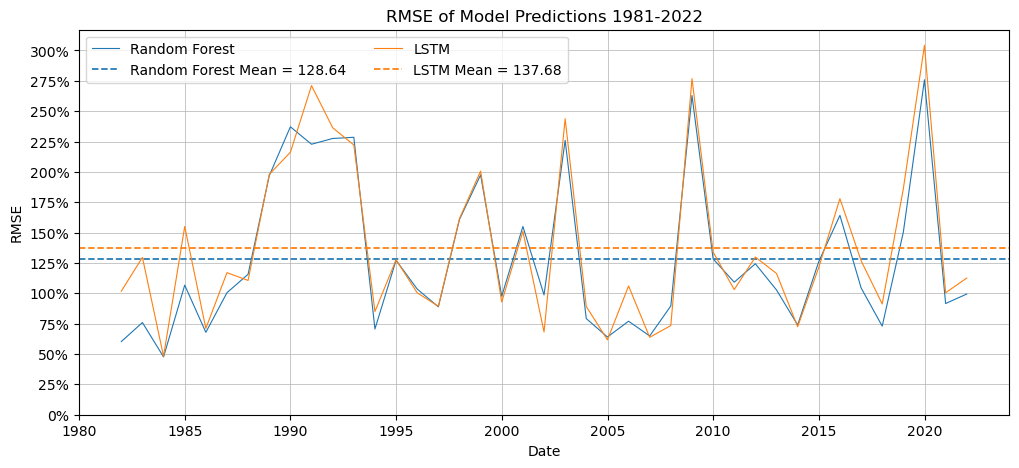

In [196]:
plt.figure(figsize=(12, 5))
for results in [(rf_results, 'Random Forest'), (lstm_results, 'LSTM')]:
    line, = plt.plot(pd.date_range('1981-12-31', '2021-12-31', freq='Y'), np.sqrt(results[0].mse)*100, label=results[1], linewidth=0.8)
    mean = "{:.2f}".format(np.mean(np.sqrt(results[0].mse)*100))
    plt.axhline(y=np.mean(np.sqrt(results[0].mse)*100), color=line.get_color(), linestyle='--', label = f'{results[1]} Mean = {mean}', linewidth=1.25)
plt.legend(loc='best', ncols=2)
plt.grid(linewidth=0.5)
plt.xlabel('Date')
plt.ylabel('RMSE')
print(plt.gca().get_ylim()[1])
plt.title('RMSE of Model Predictions 1981-2022')
plt.ylim(0, plt.gca().get_ylim()[1])
plt.gca().set_yticks(np.arange(0, plt.gca().get_ylim()[1], 25))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

# Return Performance

## Get Cumulative Returns

In [17]:
def cum_return_index(returns, funds=100):
    cum_returns = [funds]
    for i, ret in enumerate(returns):
        cum_returns.append(cum_returns[i]*(1+ret))
    return cum_returns

def get_cum_returns(model_results):
    returns_30 = cum_return_index(returns=model_results['ret_30'].tolist(), funds=100)
    returns_50 = cum_return_index(returns=model_results['ret_50'].tolist(), funds=100)
    returns_100 = cum_return_index(returns=model_results['ret_100'].tolist(), funds=100)
    returns_200 = cum_return_index(returns=model_results['ret_200'].tolist(), funds=100)
    return returns_30, returns_50, returns_100, returns_200

rf_cum_returns = list(get_cum_returns(rf_results))
lstm_cum_returns = list(get_cum_returns(lstm_results))
rf_res_cum_returns = list(get_cum_returns(rf_results_res))
lstm_res_cum_returns = list(get_cum_returns(lstm_results_res))
sp_returns_cum = cum_return_index(returns=sp_returns['vwretx'].loc[1:].tolist(), funds=100)

## Visualise Cumulative Returns against the Benchmark (S&P 500)

In [141]:
def graph_cum_returns(model_returns, model, restriction=False):
    Fig = plt.figure(figsize=(11, 6))

    plt.plot(pd.date_range('1981-12-31', '2022-12-31', freq='M'), sp_returns_cum, label='S&P 500', color='k', linewidth=0.8)
    for num_stocks in [(30, model_returns[0]), (50, model_returns[1]), (100, model_returns[2]), (200, model_returns[3])]:
        plt.plot(pd.date_range('1981-12-31', '2022-12-31', freq='Y'), num_stocks[1], label=f'Portfolio with {num_stocks[0]} stocks', linewidth=0.8)
    if restriction == False:
        plt.yscale('symlog')
    else:
        plt.ylim((0, plt.gca().get_ylim()[1]))
    plt.grid(True, linewidth=0.5)
    plt.margins(0)
    plt.legend(loc='best', framealpha=1)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.title(f'{model} Model Cumulative Performance 1981-2022')

### Random Forest (unrestricted)

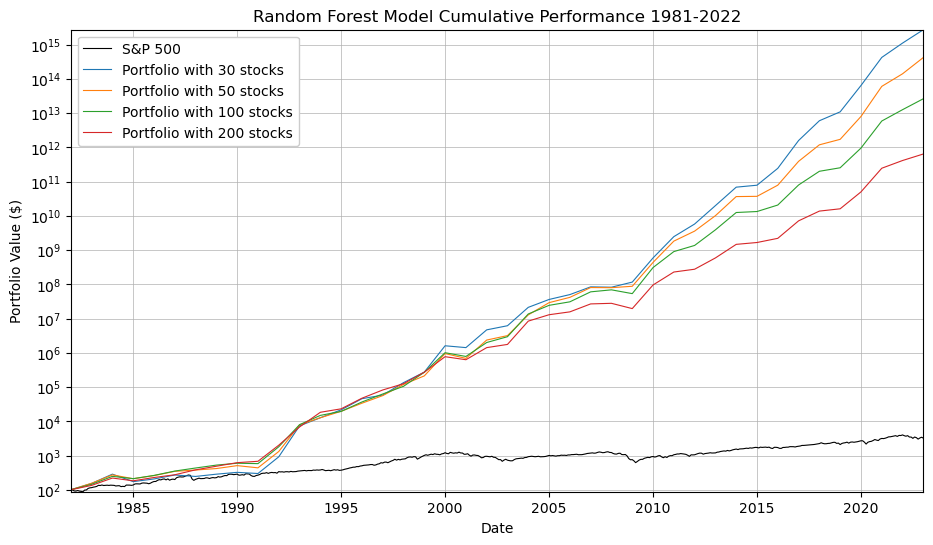

In [142]:
graph_cum_returns(rf_cum_returns, 'Random Forest', False)

### LSTM (unrestricted)

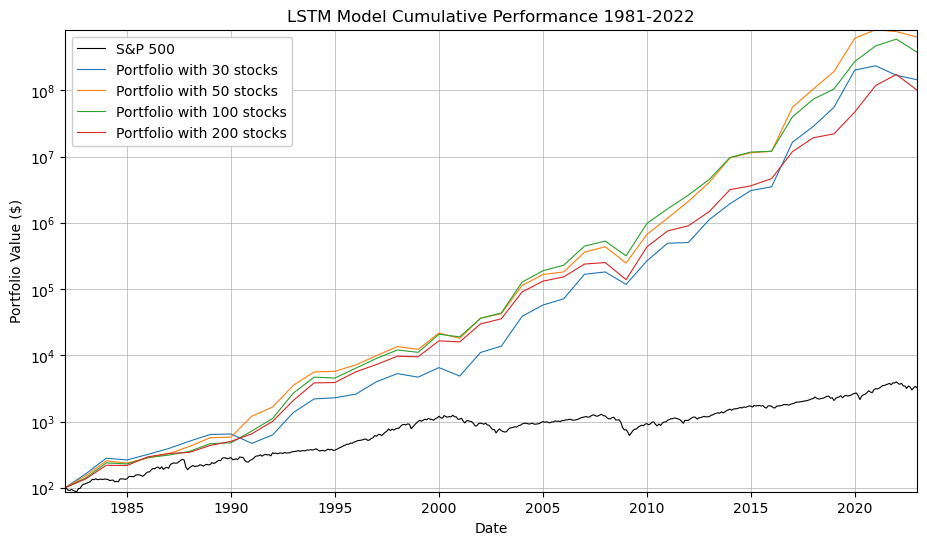

In [143]:
graph_cum_returns(lstm_cum_returns, 'LSTM', False)

### Random Forest (restricted to Mid-Cap+)

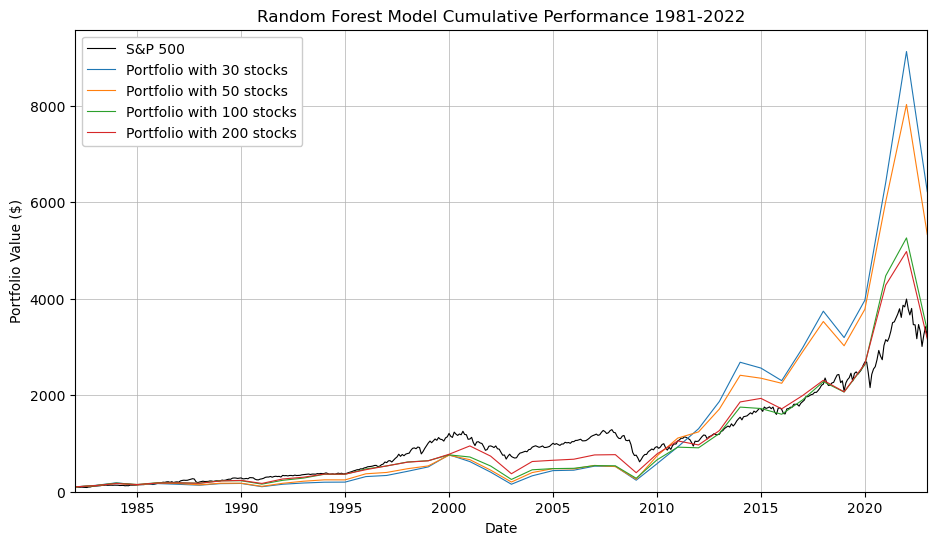

In [144]:
graph_cum_returns(rf_res_cum_returns, 'Random Forest', True)

### LSTM (restricted to Mid-Cap+)

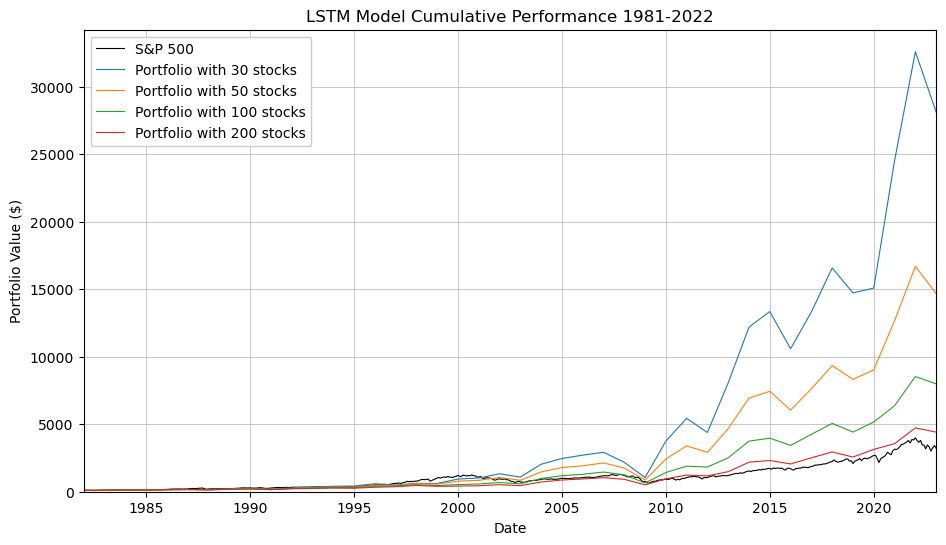

In [145]:
graph_cum_returns(lstm_res_cum_returns, 'LSTM', True)

## Get Annualised Returns

In [18]:
def annualise_returns(returns):
    annual_returns = []
    for i in range(0, len(returns), 12):
        annual_returns.append(cum_return_index(returns[i:i+12], funds=1)[-1] - 1)
    return annual_returns
        
sp_annualised_returns = annualise_returns(sp_returns['vwretx'].loc[1:].tolist())

## Visualise Annualised Returns (against benchmark S&P 500)

In [7]:
def graph_annualised_returns(model_results, model, restriction=False):
    Fig = plt.figure(figsize=(11, 6))
    plt.plot(pd.date_range('1982-12-31', '2022-12-31', freq='Y'), np.array(sp_annualised_returns)*100, label='S&P 500 Annualised Returns', linewidth=0.8, color='k')
    for num_stocks in [30, 50, 100, 200]:
        plt.plot(pd.date_range('1982-12-31', '2022-12-31', freq='Y'), model_results[f'ret_{num_stocks}']*100, label=f'Portfolio with {num_stocks} stocks', linewidth=0.8)
    mean = np.mean(model_results['ret_30'])*100
    spmean = np.mean(sp_annualised_returns)*100
    mean_str = "{:.2f}".format(mean)
    spmean_str = "{:.2f}".format(spmean)
    plt.axhline(y=mean, linestyle='--', color='red', label=f'Portfolio of 30 stocks Mean Annualised Return = {mean_str}%', linewidth=0.8)
    plt.axhline(y=spmean, linestyle='--', color='blue', label=f'S&P 500 Mean Annualised Return = {spmean_str}%', linewidth=0.8)
    print(f'Portfolio Mean: {mean}%, S&P 500 Mean: {np.mean(sp_annualised_returns)*100}%')
#     plt.annotate(f'Mean Annual Return = {mean}', xy=(0, plt.gca().get_ylim()[1]/2))
    plt.grid(True, linewidth=0.5)
    plt.margins(0.01)
    plt.legend(loc='upper left', framealpha=0.5, ncols=2, fontsize='small')
    plt.xlabel('Date')
    plt.ylabel('Mean Return')
    plt.title(f'{model} Yearly Mean Return 1981-2022')
    plt.ylim((-100, plt.gca().get_ylim()[1]))
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter()) # No decimal places

### Random Forest (no restriction)

Portfolio Mean: 161.63436323481773%, S&P 500 Mean: 10.133502912577582%


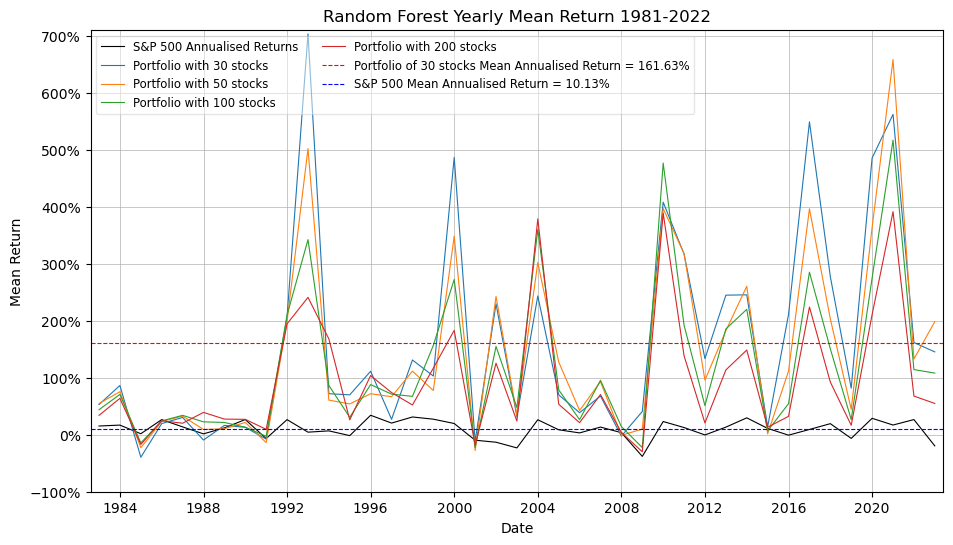

In [192]:
graph_annualised_returns(rf_results, 'Random Forest', restriction=False)

### LSTM (no restriction)

Portfolio Mean: 55.89644263549219%, S&P 500 Mean: 10.133502912577582%


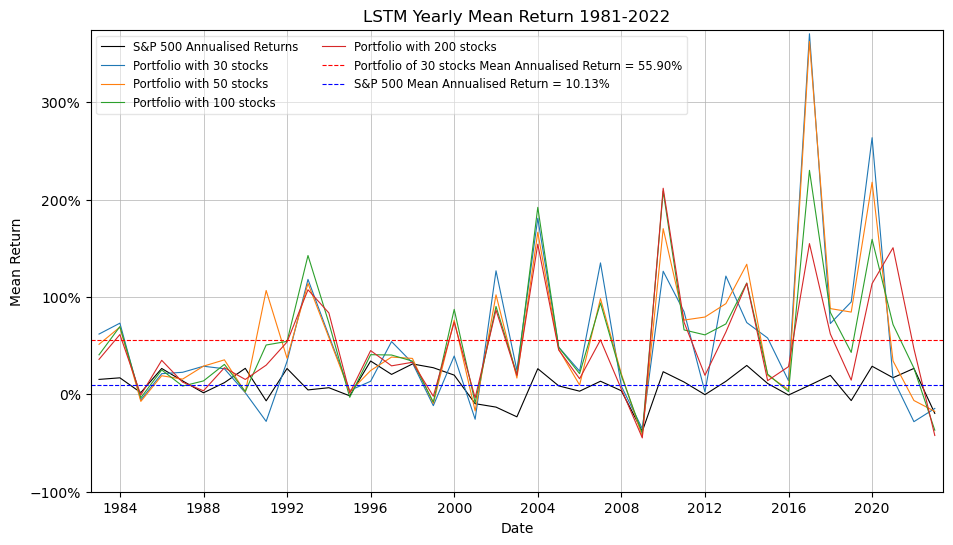

In [193]:
graph_annualised_returns(lstm_results, 'LSTM', restriction=False)

### Random Forest (with only Mid-Cap+ restriction)

Portfolio Mean: 17.521060601415353%, S&P 500 Mean: 10.133502912577582%


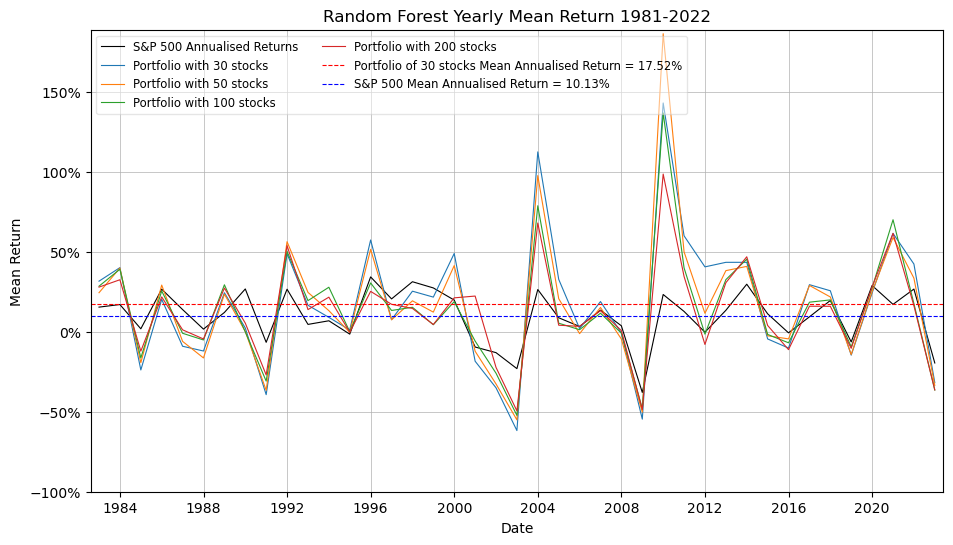

In [194]:
graph_annualised_returns(rf_results_res, 'Random Forest', restriction=True)

### LSTM (restricted to Mid-Cap+)

Portfolio Mean: 21.39604326454822%, S&P 500 Mean: 10.133502912577582%


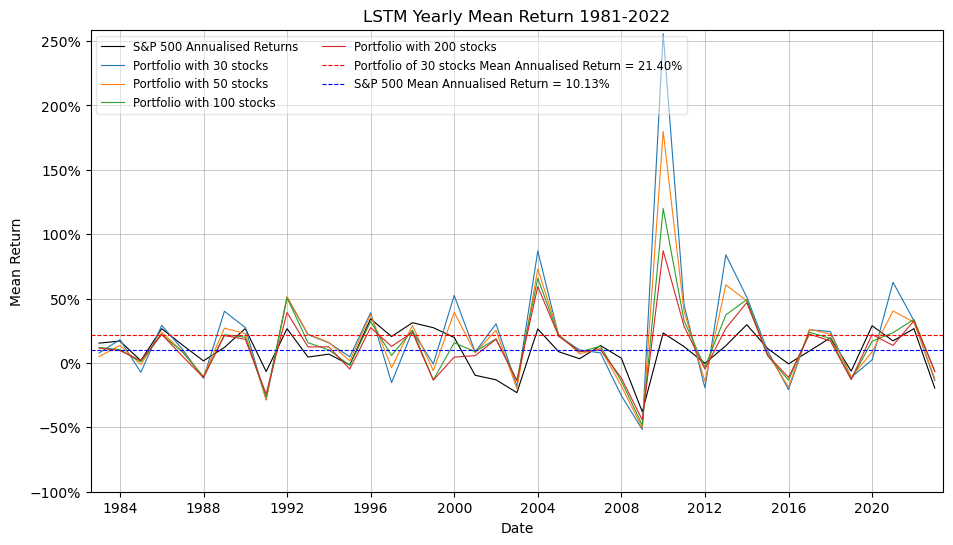

In [195]:
graph_annualised_returns(lstm_results_res, 'LSTM', restriction=True)

### Vis for Presentation of Restricted Results in Thesis

In [132]:
def graph_restricted_returns(model_returns1, model_returns2, model_results1, model_results2, model_name, restriction=False):
    Fig, ax = plt.subplots(2, 2, figsize=(16, 11), sharey='row', sharex=True)
    
    for i, model in enumerate([model_returns1, model_returns2]):
        ax[0][i].plot(pd.date_range('1981-12-31', '2022-12-31', freq='M'), sp_returns_cum, label='S&P 500', color='k', linewidth=0.8)
        for num_stocks in [(30, model[0]), (50, model[1]), (100, model[2]), (200, model[3])]:
            ax[0][i].plot(pd.date_range('1981-12-31', '2022-12-31', freq='Y'), num_stocks[1], label=f'Portfolio with {num_stocks[0]} stocks', linewidth=0.8)
        ax[0][i].grid(True, linewidth=0.5)
        if restriction == False:
            ax[0][i].set_yscale('symlog')
        ax[0][i].margins(0)
        ax[0][i].legend(loc='upper left', framealpha=1, fontsize='small')
        ax[0][0].set_ylabel('Portfolio Value ($)')
        ax[0][i].set_title(f'{i+1}) {model_name[i]} Cumulative Returns')
        if restriction == True:
            ax[0][i].set_yticks(np.arange(0, 35000, 2500))
            ax[0][i].set_ylim(0, ax[0][0].get_ylim()[1])
        else:
            pass
        
    for i, model in enumerate([model_results1, model_results2]):
        ax[1][i].plot(pd.date_range('1982-12-31', '2022-12-31', freq='Y'), np.array(sp_annualised_returns)*100, label='S&P 500 Annualised Returns', linewidth=0.8, color='k')
        for num_stocks in [30, 50, 100, 200]:
            ax[1][i].plot(pd.date_range('1982-12-31', '2022-12-31', freq='Y'), model[f'ret_{num_stocks}']*100, label=f'Portfolio with {num_stocks} stocks', linewidth=0.8)
        mean = np.mean(model['ret_30'])*100
        spmean = np.mean(sp_annualised_returns)*100
        mean_str = "{:.2f}".format(mean)
        spmean_str = "{:.2f}".format(spmean)
        ax[1][i].axhline(y=mean, linestyle='--', color='red', label=f'Portfolio of 30 stocks Mean Annualised Return = {mean_str}%', linewidth=0.8)
        ax[1][i].axhline(y=spmean, linestyle='--', color='blue', label=f'S&P 500 Mean Annualised Return = {spmean_str}%', linewidth=0.8)
        ax[1][i].grid(True, linewidth=0.5)
        ax[1][i].margins(0.01)
        ax[1][i].legend(loc='upper left', framealpha=1, fontsize='small')
        ax[1][i].set_xlabel('Date')
        ax[1][0].set_ylabel('Mean Return')
        ax[1][i].set_title(f'{i+3}) {model_name[i]} Yearly Mean Return 1981-2022')
        ax[1][i].axhline(0, linestyle=':', color='k', linewidth=0.5)
#         ax[1][i].set_ylim((-100, plt.gca().get_ylim()[1]))
        ax[1][i].yaxis.set_major_formatter(mtick.PercentFormatter()) # No decimal places
        if restriction == False:
            ax[1][0].legend(loc='upper left', framealpha=0.4, ncols=2, fontsize='x-small')
    
    plt.subplots_adjust(wspace=0.05, hspace=0.1)

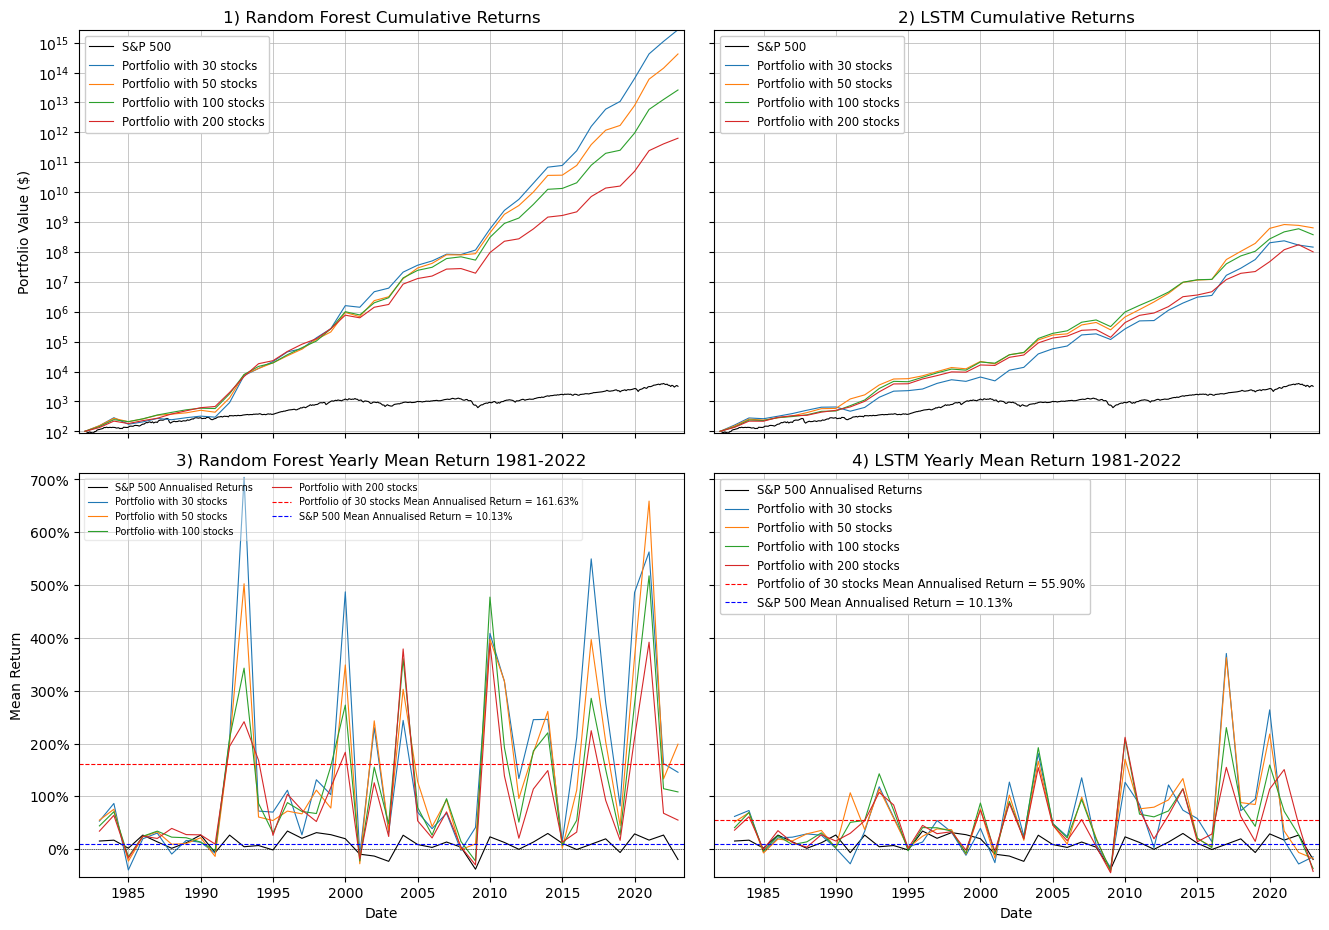

In [133]:
graph_restricted_returns(rf_cum_returns, lstm_cum_returns, rf_results, lstm_results, ['Random Forest', 'LSTM'], False)

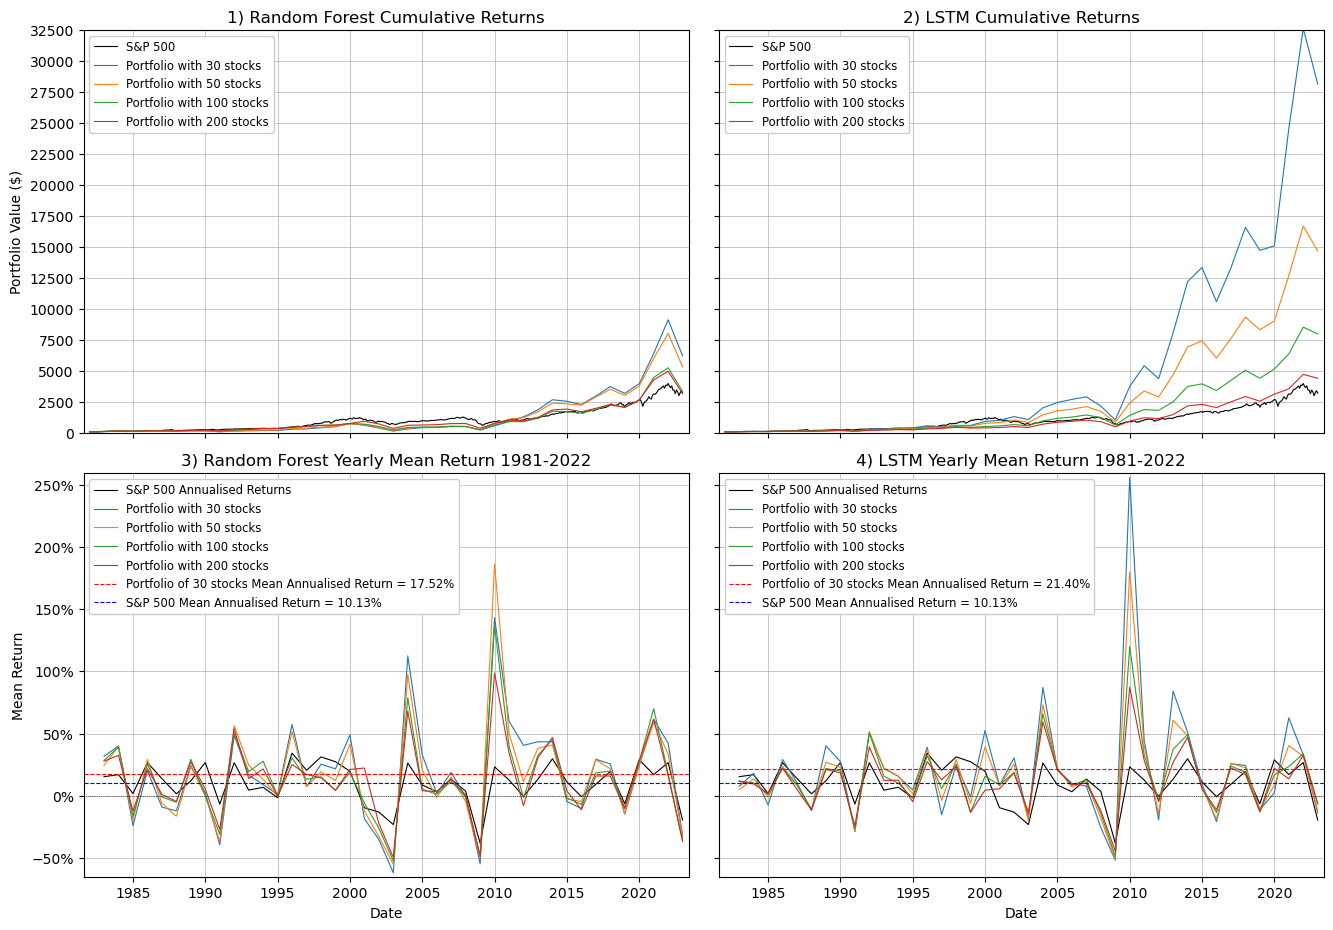

In [134]:
graph_restricted_returns(rf_res_cum_returns, lstm_res_cum_returns, rf_results_res, lstm_results_res, ['Random Forest', 'LSTM'], True)

### Mean and Stds

In [19]:
print('Mean return -', 'std return -', 'Mean ER -', 'Downside std')

for model in [('Random Forest - unrestricted', rf_results), ('LSTM - unrestricted', lstm_results), ('Random Forest - restricted', rf_results_res), ('LSTM - restricted', lstm_results_res)]:
    print(model[0], 'results:')
    for portfolio in [30, 50, 100, 200]:
        er = (model[1][f'ret_{portfolio}'].to_numpy()*100) - (np.array(sp_annualised_returns)*100)
        print(f'Portfolio {portfolio} Statistics:', "{:.4f}".format(np.mean(model[1][f'ret_{portfolio}'].to_numpy()*100)), "{:.4f}".format(np.std(model[1][f'ret_{portfolio}'].to_numpy()*100)), "{:.4f}".format(np.mean(er)), "{:.4f}".format(np.std(er[er<0])))
    print()

Mean return - std return - Mean ER - Downside std
Random Forest - unrestricted results:
Portfolio 30 Statistics: 161.6344 180.2687 151.5009 12.7827
Portfolio 50 Statistics: 143.3961 156.4740 133.2626 7.5461
Portfolio 100 Statistics: 120.5406 130.7750 110.4071 5.4510
Portfolio 200 Statistics: 96.0326 106.5086 85.8991 6.9279

LSTM - unrestricted results:
Portfolio 30 Statistics: 55.8964 78.2431 45.7629 16.0950
Portfolio 50 Statistics: 59.5730 73.2057 49.4395 11.8796
Portfolio 100 Statistics: 55.2122 60.6921 45.0787 11.7858
Portfolio 200 Statistics: 49.0009 53.3378 38.8674 10.3735

Random Forest - restricted results:
Portfolio 30 Statistics: 17.5211 39.4756 7.3876 9.9122
Portfolio 50 Statistics: 16.6377 40.8717 6.5042 8.4902
Portfolio 100 Statistics: 13.7804 33.6429 3.6469 8.5899
Portfolio 200 Statistics: 12.7281 28.8689 2.5946 7.1192

LSTM - restricted results:
Portfolio 30 Statistics: 21.3960 47.3235 11.2625 10.2784
Portfolio 50 Statistics: 17.4899 35.7715 7.3564 9.0810
Portfolio 100 St

## Statistical Tests

### F-Tests (to test equal variance assumption)

In [20]:
from scipy import stats

def f_test(group1, group2):
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = group1.size-1
    dun = group2.size-1
    p_value = 1-stats.f.cdf(f, nun, dun)
    return f, p_value

print("F-TESTS:\n")

for model in [('Random Forest - unrestricted', rf_results), ('LSTM - unrestricted', lstm_results), ('Random Forest - restricted', rf_results_res), ('LSTM - restricted', lstm_results_res)]:
    print(model[0], 'results:')
    for portfolio in [30, 50, 100, 200]:
        print(f'Portfolio {portfolio} p-value:', "{:.4f}".format(f_test(model[1][f'ret_{portfolio}'].to_numpy(), np.array(sp_annualised_returns))[1]))
    print()

F-TESTS:

Random Forest - unrestricted results:
Portfolio 30 p-value: 0.0000
Portfolio 50 p-value: 0.0000
Portfolio 100 p-value: 0.0000
Portfolio 200 p-value: 0.0000

LSTM - unrestricted results:
Portfolio 30 p-value: 0.0000
Portfolio 50 p-value: 0.0000
Portfolio 100 p-value: 0.0000
Portfolio 200 p-value: 0.0000

Random Forest - restricted results:
Portfolio 30 p-value: 0.0000
Portfolio 50 p-value: 0.0000
Portfolio 100 p-value: 0.0000
Portfolio 200 p-value: 0.0001

LSTM - restricted results:
Portfolio 30 p-value: 0.0000
Portfolio 50 p-value: 0.0000
Portfolio 100 p-value: 0.0006
Portfolio 200 p-value: 0.0151



In [21]:
print("One-tail t-tests:\n")

for model in [('Random Forest - unrestricted', rf_results), ('LSTM - unrestricted', lstm_results), ('Random Forest - restricted', rf_results_res), ('LSTM - restricted', lstm_results_res)]:
    print(model[0], 'results:')
    for portfolio in [30, 50, 100, 200]:
        print(f'Portfolio {portfolio} p-value 1-tail:', "{:.4f}".format(stats.ttest_ind(model[1][f'ret_{portfolio}'].to_numpy(), sp_annualised_returns, equal_var = False)[1] / 2))
    print()

One-tail t-tests:

Random Forest - unrestricted results:
Portfolio 30 p-value 1-tail: 0.0000
Portfolio 50 p-value 1-tail: 0.0000
Portfolio 100 p-value 1-tail: 0.0000
Portfolio 200 p-value 1-tail: 0.0000

LSTM - unrestricted results:
Portfolio 30 p-value 1-tail: 0.0004
Portfolio 50 p-value 1-tail: 0.0001
Portfolio 100 p-value 1-tail: 0.0000
Portfolio 200 p-value 1-tail: 0.0000

Random Forest - restricted results:
Portfolio 30 p-value 1-tail: 0.1388
Portfolio 50 p-value 1-tail: 0.1764
Portfolio 100 p-value 1-tail: 0.2691
Portfolio 200 p-value 1-tail: 0.3103

LSTM - restricted results:
Portfolio 30 p-value 1-tail: 0.0801
Portfolio 50 p-value 1-tail: 0.1200
Portfolio 100 p-value 1-tail: 0.2025
Portfolio 200 p-value 1-tail: 0.3385



## Information Ratios and Sortino-modified Information Ratios Performance

In [38]:
def calc_sort_ir(returns, risk_free):
    er = returns.to_numpy() - np.array(risk_free)
    er_d = er
    er_d[er_d>0] = 0
    return (np.mean(returns) - np.mean(risk_free)) / np.std(er_d)

def print_sort_ir_performance(model_results, model):
    print(f'\n{model.upper()} Sortino-modified Information Ratios')
    for i in [30, 50, 100, 200]:
        print(f'Top {i} portfolio SR =', calc_sort_ir(model_results[f"ret_{i}"], sp_annualised_returns))

print_sort_ir_performance(rf_results, 'Random Forest Unrestricted')
print_sort_ir_performance(lstm_results, 'LSTM Unrestricted')
print_sort_ir_performance(rf_results_res, 'Random Forest Restricted (to mid-cap+ stocks)')
print_sort_ir_performance(lstm_results_res, 'LSTM Restricted (to mid-cap+ stocks)')


RANDOM FOREST UNRESTRICTED Sortino-modified Information Ratios
Top 30 portfolio SR = 22.034557523747605
Top 50 portfolio SR = 26.964412528409092
Top 100 portfolio SR = 29.67195069601617
Top 200 portfolio SR = 27.030633266656302

LSTM UNRESTRICTED Sortino-modified Information Ratios
Top 30 portfolio SR = 3.959522656061147
Top 50 portfolio SR = 5.863090614132936
Top 100 portfolio SR = 6.509146098404533
Top 200 portfolio SR = 6.597464631438777

RANDOM FOREST RESTRICTED (TO MID-CAP+ STOCKS) Sortino-modified Information Ratios
Top 30 portfolio SR = 0.7332113370340437
Top 50 portfolio SR = 0.6981631063881821
Top 100 portfolio SR = 0.434899393609216
Top 200 portfolio SR = 0.34880811241532855

LSTM RESTRICTED (TO MID-CAP+ STOCKS) Sortino-modified Information Ratios
Top 30 portfolio SR = 1.1384894041539777
Top 50 portfolio SR = 0.8708329737270633
Top 100 portfolio SR = 0.5347821036471007
Top 200 portfolio SR = 0.24649938769419194


# Picked Stocks Analysis and Reality Testing

## Preparation

Need to do this to get the same dataset as used in the experimental set up

In [3]:
df = wr.s3.read_csv('s3://dsp-data-vq22301/final_dataset_with_cap.csv')
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df = df.sort_values(by=['gvkey', 'public_date'], ascending=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/awswrangler/s3/_read_text_core.py:112: DtypeWarning: Columns (77) have mixed types. Specify dtype option on import or set low_memory=False.
  df: pd.DataFrame = parser_func(f, **pandas_kwargs)


In [4]:
inputs = ['CAPEI', 'bm',
       'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf',
       'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity',
       'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap',
       'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt',
       'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at',
       'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct',
       'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets',
       'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
       'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc',
       'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing',
       'divyield', 'MthCap', 'FEDFUNDS', '1yr_inf_rate', '1mo_inf_rate', '1yr_GDP', '1mo_GDP', 'DGS10']

target = '1yr_return'

cols_to_drop = []
cols_to_keep = []

for i, value in enumerate(df[inputs].isnull().sum()):
    if value > 120000:
        cols_to_drop.append(df[inputs].columns[i])
    else:
        cols_to_keep.append(df[inputs].columns[i])

## What is the Market Cap split in terms of the stocks picked?

In [7]:
def get_cap_distribution(model, df=df, cap_restriction=False):
    caps_ordered = ['Nano Cap', 'Micro Cap', 'Small Cap', 'Mid Cap', 'Large Cap', 'Mega Cap']
    
    if model == 'lstm':
        df_test = df
    elif model == 'rf':
        df_test = df.loc[df[cols_to_keep].dropna(how='any').index, :]
    else:
        raise Exception("Model not recognised") 
        
    if cap_restriction == True:
        df_test = df_test[df_test['cap'].isin(['Mid Cap', 'Large Cap', 'Mega Cap'])]
    else:
        pass
    print(df_test.cap.unique())
    df_cap = pd.DataFrame(data=0, columns=['30 Stocks', '50 Stocks', '100 Stocks', '200 Stocks'], index=caps_ordered)
    
    df_test = df_test.reset_index(drop=True)
    for year in range(1981, 2022):
        if cap_restriction == False:
            if model == 'rf':
                results_yr = wr.s3.read_csv(f's3://dsp-data-vq22301/rf_test_results/rf_results_{year}_raw.csv')
            if model == 'lstm':
                results_yr = wr.s3.read_csv(f's3://dsp-data-vq22301/lstm_test_results/lstm_results_{year}_raw.csv')
        else:
            if model == 'rf':
                results_yr = wr.s3.read_csv(f's3://dsp-data-vq22301/rf_test_results/cap_limit_results/rf_results_Mi_{year}_raw.csv')
            if model == 'lstm':
                try:
                    results_yr = wr.s3.read_csv(f's3://dsp-data-vq22301/lstm_test_results/cap_limit_results/lstm_results_Mi_{year}_raw.csv')
                except:
                    pass
        df_temp = df_test[df_test['public_date'] == f'{year}-12-31'].reset_index(drop=True)
        for portfolio in [30, 50, 100, 200]:
            for cap in caps_ordered:
                try:
                    df_cap.loc[cap, f'{portfolio} Stocks'] += df_temp.loc[results_yr.ytest_pred_raw.to_numpy().argsort(), 'cap'].iloc[-portfolio:].value_counts().loc[cap]
                except:
                    df_cap.loc[cap, f'{portfolio} Stocks'] += 0
    return df_cap

def display_cap_distribution(df_cap, model, cap_restriction=False):
    df_cap_pct = (df_cap / df_cap.sum())*100
    
    x = df_cap_pct.columns
    y1 = df_cap_pct.loc['Nano Cap', :].to_numpy()
    y2 = df_cap_pct.loc['Micro Cap', :].to_numpy()
    y3 = df_cap_pct.loc['Small Cap', :].to_numpy()
    y4 = df_cap_pct.loc['Mid Cap', :].to_numpy()
    y5 = df_cap_pct.loc['Large Cap', :].to_numpy()
    y6 = df_cap_pct.loc['Mega Cap', :].to_numpy()

    plt.bar(x, y1)
    plt.bar(x, y2, bottom=y1)
    plt.bar(x, y3, bottom=y1+y2)
    plt.bar(x, y4, bottom=y1+y2+y3)
    plt.bar(x, y5, bottom=y1+y2+y3+y4)
    plt.bar(x, y6, bottom=y1+y2+y3+y4+y5)
    
    plt.xlabel("Portfolio")
    plt.ylabel("Composition ")
    plt.legend(df_cap_pct.index, loc='best')
    plt.title(f'{model} Portfolio Compositions for all Periods 1981-2022 - Cap Restricted to Min Mid-Cap = {cap_restriction}')
    plt.ylim(0, 100)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.yticks(np.arange(0, 105, 5))
    plt.grid(axis='y', linewidth=0.4, linestyle='--')
    plt.show()

### Random Forest (no restriction)

['Small Cap' 'Micro Cap' 'Mid Cap' 'Large Cap' 'Nano Cap' 'Mega Cap']


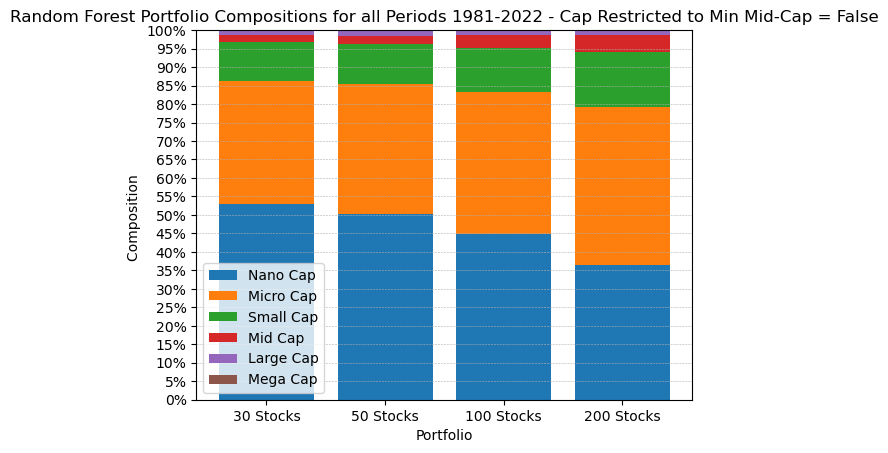

In [8]:
df_cap = get_cap_distribution('rf', df, False)
display_cap_distribution(df_cap, 'Random Forest', False)

### Random Forest (restricted to minimum Mid-Cap stocks)

['Mid Cap' 'Large Cap' 'Mega Cap']


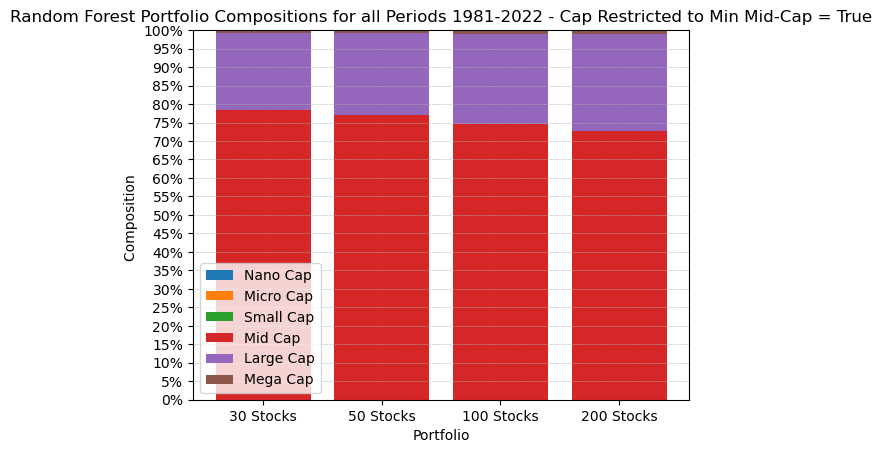

In [9]:
df_cap = get_cap_distribution('rf', df, True)
display_cap_distribution(df_cap, 'Random Forest', True)

### LSTM (no restriction)

['Small Cap' 'Micro Cap' 'Mid Cap' 'Large Cap' 'Nano Cap' 'Mega Cap']


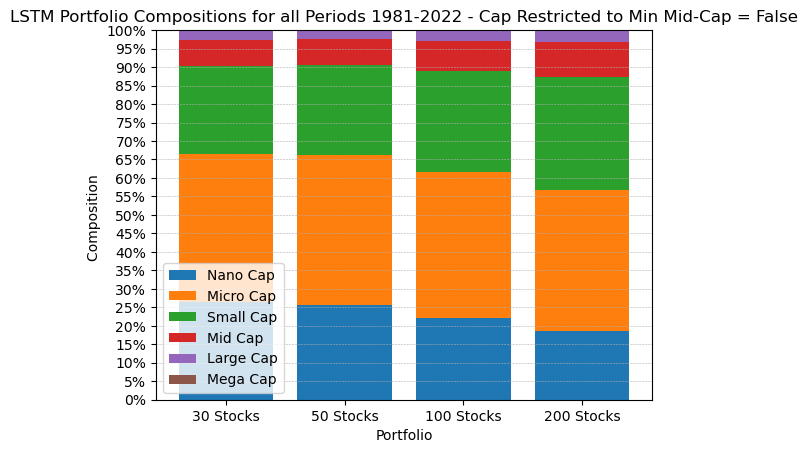

In [10]:
df_cap = get_cap_distribution('lstm', df, False)
display_cap_distribution(df_cap, 'LSTM', False)

### LSTM (restricted to Mid-Cap+)

['Mid Cap' 'Large Cap' 'Mega Cap']


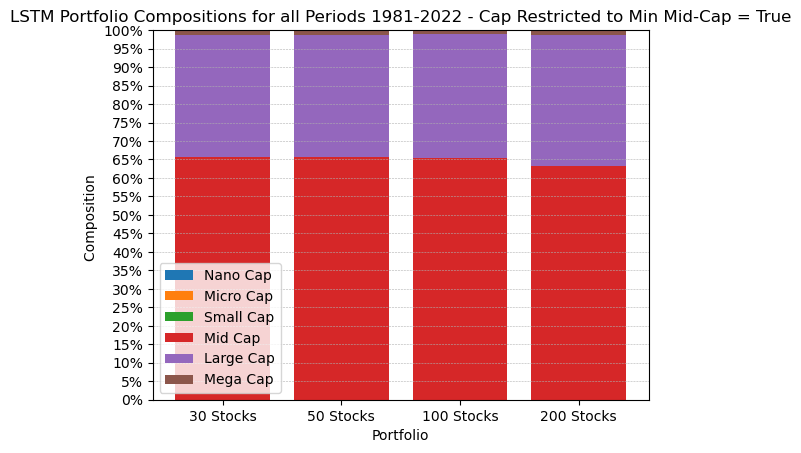

In [11]:
df_cap = get_cap_distribution('lstm', df, True)
display_cap_distribution(df_cap, 'LSTM', True)

### Composition for Display in Thesis

In [12]:
def display_cap_distribution_two(df_cap1, df_cap2, models=['Random Forest', 'LSTM']):
    df_cap_pct1 = (df_cap1 / df_cap1.sum())*100
    df_cap_pct2 = (df_cap2 / df_cap2.sum())*100
    
    Fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    
    for i, df_cap_pct in enumerate([df_cap_pct1, df_cap_pct2]):
        x = df_cap_pct.columns
        y1 = df_cap_pct.loc['Nano Cap', :].to_numpy()
        y2 = df_cap_pct.loc['Micro Cap', :].to_numpy()
        y3 = df_cap_pct.loc['Small Cap', :].to_numpy()
        y4 = df_cap_pct.loc['Mid Cap', :].to_numpy()
        y5 = df_cap_pct.loc['Large Cap', :].to_numpy()
        y6 = df_cap_pct.loc['Mega Cap', :].to_numpy()

        ax[i].bar(x, y1)
        ax[i].bar(x, y2, bottom=y1)
        ax[i].bar(x, y3, bottom=y1+y2)
        ax[i].bar(x, y4, bottom=y1+y2+y3)
        ax[i].bar(x, y5, bottom=y1+y2+y3+y4)
        ax[i].bar(x, y6, bottom=y1+y2+y3+y4+y5)
    
        ax[i].set_xlabel("Portfolio")
        ax[i].set_xticklabels(x, fontsize=9)
        ax[i].set_yticklabels(np.arange(0, 105, 5), fontsize=9)
        ax[i].legend(df_cap_pct.index, loc='lower left', fontsize='small')
        ax[i].set_title(f'{models[i]}')
        ax[i].set_ylim(0, 100)
        ax[i].yaxis.set_major_formatter(mtick.PercentFormatter())
        ax[i].set_yticks(np.arange(0, 105, 5))
        ax[i].grid(axis='y', linewidth=0.4, linestyle='--')
    ax[0].set_ylabel("Stock Composition")
    plt.suptitle('Portfolio Composition for all Stocks Selected 1981-2022')

['Small Cap' 'Micro Cap' 'Mid Cap' 'Large Cap' 'Nano Cap' 'Mega Cap']
['Small Cap' 'Micro Cap' 'Mid Cap' 'Large Cap' 'Nano Cap' 'Mega Cap']


/tmp/ipykernel_9433/4021141218.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(x, fontsize=9)
/tmp/ipykernel_9433/4021141218.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(np.arange(0, 105, 5), fontsize=9)


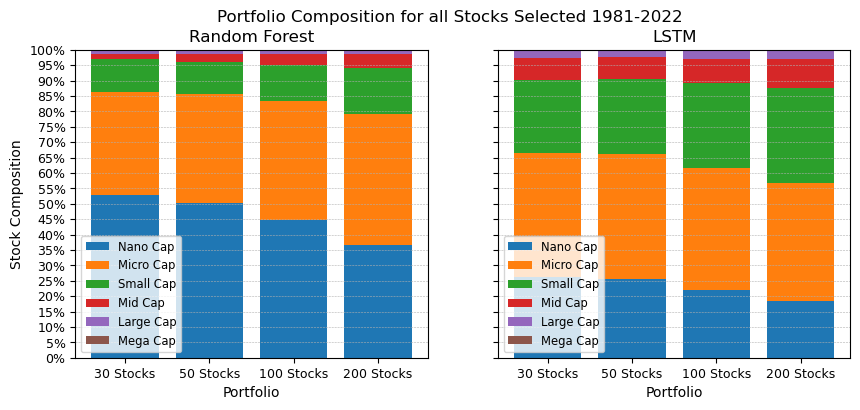

In [241]:
df_cap_rf = get_cap_distribution('rf', df, False)
df_cap_lstm = get_cap_distribution('lstm', df, False)

display_cap_distribution_two(df_cap_rf, df_cap_lstm)

['Mid Cap' 'Large Cap' 'Mega Cap']
['Mid Cap' 'Large Cap' 'Mega Cap']


/tmp/ipykernel_6935/4021141218.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(x, fontsize=9)
/tmp/ipykernel_6935/4021141218.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(np.arange(0, 105, 5), fontsize=9)


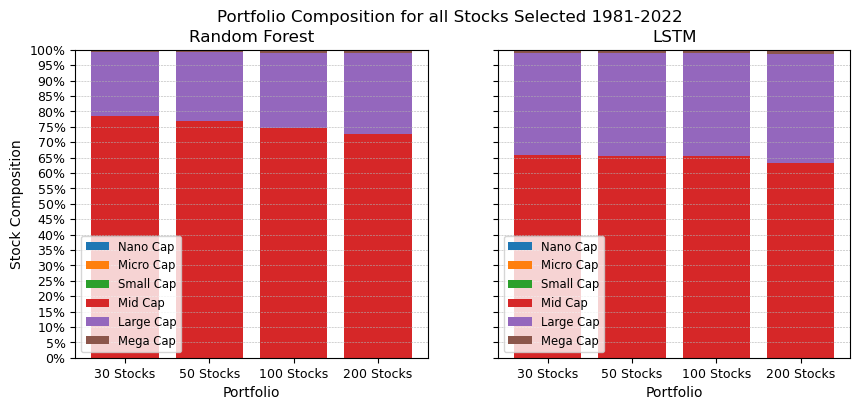

In [13]:
df_cap_rf_res = get_cap_distribution('rf', df, True)
df_cap_lstm_res = get_cap_distribution('lstm', df, True)

display_cap_distribution_two(df_cap_rf_res, df_cap_lstm_res)

# Feature Importance

In [5]:
glossary = {
    'CAPEI': {'Ratio': 'Shillers Cyclically Adjusted P/E Ratio', 'Category': 'Valuation', 'Formula': 'Multiple of Market Value of Equity to 5-year moving average of Net Income'},
    'bm': {'Ratio': 'Book/Market', 'Category': 'Valuation', 'Formula': 'Book Value of Equity as a fraction of Market Value of Equity'},
    'evm': {'Ratio': 'Enterprise Value Multiple', 'Category': 'Valuation', 'Formula': 'Multiple of Enterprise Value to EBITDA'},
    'pe_op_basic': {'Ratio': 'Price/Operating Earnings (Basic, Excl. EI)', 'Category': 'Valuation', 'Formula': 'Price to Operating EPS, excl. Extraordinary Items (Basic)'},
    'pe_op_dil': {'Ratio': 'Price/Operating Earnings (Diluted, Excl. EI)', 'Category': 'Valuation', 'Formula': 'Price to Operating EPS, excl. Extraordinary Items (Diluted)'},
    'pe_exi': {'Ratio': 'P/E (Diluted, Excl. EI)', 'Category': 'Valuation', 'Formula': 'Price-to-Earnings, excl. Extraordinary Items (diluted)'},
    'pe_inc': {'Ratio': 'P/E (Diluted, Incl. EI)', 'Category': 'Valuation', 'Formula': 'Price-to-Earnings, incl. Extraordinary Items (diluted)'},
    'ps': {'Ratio': 'Price/Sales', 'Category': 'Valuation', 'Formula': 'Multiple of Market Value of Equity to Sales'},
    'pcf': {'Ratio': 'Price/Cash flow', 'Category': 'Valuation', 'Formula': 'Multiple of Market Value of Equity to Net Cash Flow from Operating Activities'},
    'dpr': {'Ratio': 'Dividend Payout Ratio', 'Category': 'Valuation', 'Formula': 'Dividends as a fraction of Income Before Extra. Items'},
    'npm': {'Ratio': 'Net Profit Margin', 'Category': 'Profitability', 'Formula': 'Net Income as a fraction of Sales'},
    'opmbd': {'Ratio': 'Operating Profit Margin Before Depreciation', 'Category': 'Profitability', 'Formula': 'Operating Income Before Depreciation as a fraction of Sales'},
    'opmad': {'Ratio': 'Operating Profit Margin After Depreciation', 'Category': 'Profitability', 'Formula': 'Operating Income After Depreciation as a fraction of Sales'},
    'gpm': {'Ratio': 'Gross Profit Margin', 'Category': 'Profitability', 'Formula': 'Gross Profit as a fraction of Sales'},
    'ptpm': {'Ratio': 'Pre-tax Profit Margin', 'Category': 'Profitability', 'Formula': 'Pretax Income as a fraction of Sales'},
    'cfm': {'Ratio': 'Cash Flow Margin', 'Category': 'Financial Soundness', 'Formula': 'Income before Extraordinary Items and Depreciation as a fraction of Sales'},
    'roa': {'Ratio': 'Return on Assets', 'Category': 'Profitability', 'Formula': 'Operating Income Before Depreciation as a fraction of average TotalAssets based on most recent two periods'},
    'roe': {'Ratio': 'Return on Equity', 'Category': 'Profitability', 'Formula': 'Net Income as a fraction of average Book Equity based on most recent two periods, where Book Equity is defined as the sum of Total Parent Stockholders Equity and Deferred Taxes and Investment Tax Credit'},
    'roce': {'Ratio': 'Return on Capital Employed', 'Category': 'Profitability', 'Formula': 'Earnings Before Interest and Taxes as a fraction of average Capital Employed based on most recent two periods, where Capital Employed is the sum of Debt in Long-term and Current Liabilities and Common/Ordinary Equity'},
    'efftax': {'Ratio': 'Effective Tax Rate', 'Category': 'Profitability', 'Formula': 'Income Tax as a fraction of Pretax Income'},
    'aftret_eq': {'Ratio': 'After-tax Return on Average Common Equity', 'Category': 'Profitability', 'Formula': 'Net Income as a fraction of average of Common Equity based on most recent two periods'},
    'aftret_invcapx': {'Ratio': 'After-tax Return on Invested Capital', 'Category': 'Profitability', 'Formula': 'Net Income plus Interest Expenses as a fraction of Invested Capital'},
    'aftret_equity': {'Ratio': 'After-tax Return on Total Stockholders’ Equity', 'Category': 'Profitability', 'Formula': 'Net Income as a fraction of average of Total Shareholders’ Equity based on most recent two periods'},
    'pretret_noa': {'Ratio': 'Pre-tax return on Net Operating Assets', 'Category': 'Profitability', 'Formula': 'Operating Income After Depreciation as a fraction of average Net Operating Assets (NOA) based on most recent two periods, where NOA is defined as the sum of Property Plant and Equipment and Current Assets minus Current Liabilities'},
    'pretret_earnat': {'Ratio': 'Pre-tax Return on Total Earning Assets', 'Category': 'Profitability', 'Formula': 'Operating Income After Depreciation as a fraction of average Total Earnings Assets (TEA) based on most recent two periods, where TEA is defined as the sum of Property Plant and Equipment and Current Assets'},
    'GProf': {'Ratio': 'Gross Profit/Total Assets', 'Category': 'Profitability', 'Formula': 'Gross Profitability as a fraction of Total Assets'},
    'equity_invcap': {'Ratio': 'Common Equity/Invested Capital', 'Category': 'Capitalisation', 'Formula': 'Common Equity as a fraction of Invested Capital'},
    'debt_invcap': {'Ratio': 'Long-term Debt/Invested Capital', 'Category': 'Capitalisation', 'Formula': 'Long-term Debt as a fraction of Invested Capital'},
    'totdebt_invcap': {'Ratio': 'Total Debt/Invested Capital', 'Category': 'Capitalisation', 'Formula': 'Total Debt (Long-term and Current) as a fraction of Invested Capital'},
    'capital_ratio': {'Ratio': 'Capitalization Ratio', 'Category': 'Capitalisation', 'Formula': 'Total Long-term Debt as a fraction of the sum of Total Long-term Debt, Common/Ordinary Equity and Preferred Stock'},
    'int_debt': {'Ratio': 'Interest/Average Long-term Debt', 'Category': 'Financial Soundness', 'Formula': 'Interest as a fraction of average Long-term debt based on most recent two periods'},
    'int_totdebt': {'Ratio': 'Interest/Average Total Debt', 'Category': 'Financial Soundness', 'Formula': 'Interest as a fraction of average Total Debt based on most recent two periods'},
    'cash_lt': {'Ratio': 'Cash Balance/Total Liabilities', 'Category': 'Financial Soundness', 'Formula': 'Cash Balance as a fraction of Total Liabilities'},
    'invt_act': {'Ratio': 'Inventory/Current Assets', 'Category': 'Financial Soundness', 'Formula': 'Inventories as a fraction of Current Assets'},
    'rect_act': {'Ratio': 'Receivables/Current Assets', 'Category': 'Financial Soundness', 'Formula': 'Accounts Receivables as a fraction of Current Assets'},
    'debt_at': {'Ratio': 'Total Debt/Total Assets', 'Category': 'Solvency', 'Formula': 'Total Liabilities as a fraction of Total Assets'},
    'debt_ebitda': {'Ratio': 'debt_ebitda', 'Category': 'Financial Soundness', 'Formula': 'Gross Debt as a fraction of EBITDA'},
    'short_debt': {'Ratio': 'Short-Term Debt/Total Debt', 'Category': 'Financial Soundness', 'Formula': 'Short-term Debt as a fraction of Total Debt'},
    'curr_debt': {'Ratio': 'Current Liabilities/Total Liabilities', 'Category': 'Financial Soundness', 'Formula': 'Current Liabilities as a fraction of Total Liabilities'},
    'lt_debt': {'Ratio': 'Long-term Debt/Total Liabilities', 'Category': 'Financial Soundness', 'Formula': 'Long-term Debt as a fraction of Total Liabilities'},
    'profit_lct': {'Ratio': 'Profit Before Depreciation/Current Liabilities', 'Category': 'Financial Soundness', 'Formula': 'Operating Income before D&A as a fraction of Current Liabilities'},
    'ocf_lct': {'Ratio': 'Operating CF/Current Liabilities', 'Category': 'Financial Soundess', 'Formula': 'Operating Cash Flow as a fraction of Current Liabilities'},
    'cash_debt': {'Ratio': 'Cash Flow/Total Debt', 'Category': 'Financial Soundness', 'Formula': 'Operating Cash Flow as a fraction of Total Debt'},
    'fcf_ocf': {'Ratio': 'Free Cash Flow/Operating Cash Flow', 'Category': 'Financial Soundness', 'Formula': 'Free Cash Flow as a fraction of Operating Cash Flow, where Free Cash Flow is defined as the difference between Operating Cash Flow and Capital Expenditures'},
    'lt_ppent': {'Ratio': 'Total Liabilities/Total Tangible Assets', 'Category': 'Financial Soundness', 'Formula': 'Total Liabilities to Total Tangible Assets'},
    'dltt_be': {'Ratio': 'Long-term Debt/Book Equity', 'Category': 'Financial Soundess', 'Formula': 'Long-term Debt to Book Equity'},
    'debt_assets': {'Ratio': 'Total Debt/Total Assets', 'Category': 'Solvency', 'Formula': 'Total Debt as a fraction of Total Assets'},
    'debt_capital': {'Ratio': 'Total Debt/Capital', 'Category': 'Solvency', 'Formula': 'Total Debt as a fraction of Total Capital, where Total Debt is defined as the sum of Accounts Payable and Total Debt in Current and Long-term Liabilities, and Total Capital is defined as the sum of Total Debt and Total Equity (common and preferred)'},
    'de_ratio': {'Ratio': 'Total Debt/Equity', 'Category': 'Solvency', 'Formula': 'Total Liabilities to Shareholders’ Equity (common and preferred)'},
    'intcov': {'Ratio': 'After-tax Interest Coverage', 'Category': 'Solvency', 'Formula': 'Multiple of After-tax Income to Interest and Related Expenses'},
    'intcov_ratio': {'Ratio': 'Interest Coverage Ratio', 'Category': 'Solvency', 'Formula': 'Multiple of Earnings Before Interest and Taxes to Interest and Related Expenses'},
    'cash_ratio': {'Ratio': 'Cash Ratio', 'Category': 'Liquidity', 'Formula': 'Cash and Short-term Investments as a fraction of Current Liabilities'},
    'quick_ratio': {'Ratio': 'Quick Ratio (Acid Test)', 'Category': 'Liquidity', 'Formula': 'Quick Ratio: Current Assets net of Inventories as a fraction of Current Liabilities'},
    'curr_ratio': {'Ratio': 'Current Ratio', 'Category': 'Liquidity', 'Formula': 'Current Assets as a fraction of Current Liabilities'},
    'cash_conversion': {'Ratio': 'Cash Conversion Cycle (Days)', 'Category': 'Liquidity', 'Formula': 'Inventories per daily COGS plus Account Receivables per daily Sales minus Account Payables per daily COGS'},
    'inv_turn': {'Ratio': 'Inventory Turnover', 'Category': 'Efficiency', 'Formula': 'COGS as a fraction of the average Inventories based on the most recent two periods'},
    'at_turn': {'Ratio': 'Asset Turnover', 'Category': 'Efficiency', 'Formula': 'Sales as a fraction of the average Total Assets based on the most recent two periods'},
    'rect_turn': {'Ratio': 'Receivables Turnover', 'Category': 'Efficiency', 'Formula': 'Sales as a fraction of the average of Accounts Receivables based on the most recent two periods'},
    'pay_turn': {'Ratio': 'Payables Turnover', 'Category': 'Efficiency', 'Formula': 'COGS and change in Inventories as a fraction of the average of Accounts Payable based on the most recent two periods'},
    'sale_invcap': {'Ratio': 'Sales/Invested Capital', 'Category': 'Efficiency', 'Formula': 'Sales per dollar of Invested Capital'},
    'sale_equity': {'Ratio': 'Sales/Stockholders Equity', 'Category': 'Efficiency', 'Formula': 'Sales per dollar of total Stockholders’ Equity'},
    'sale_nwc': {'Ratio': 'Sales/Working Capital', 'Category': 'Efficiency', 'Formula': 'Sales per dollar of Working Capital, defined as difference between Current Assets and Current Liabilities'},
    'rd_sale': {'Ratio': 'Research and Development/Sales', 'Category': 'Other', 'Formula': 'R&D expenses as a fraction of Sales'},
    'adv_sale': {'Ratio': 'Avertising Expenses/Sales', 'Category': 'Other', 'Formula': 'Advertising Expenses as a fraction of Sales'},
    'staff_sale': {'Ratio': 'Labor Expenses/Sales', 'Category': 'Other', 'Formula': 'Labor Expenses as a fraction of Sales'},
    'accrual': {'Ratio': 'Accruals/Average Assets', 'Category': 'Other', 'Formula': 'Accruals as a fraction of average Total Assets based on most recent two periods'},
    'ptb': {'Ratio': 'Price/Book', 'Category': 'Valuation', 'Formula': 'Multiple of Market Value of Equity to Book Value of Equity'},
    'PEG_trailing': {'Ratio': 'Trailing P/E to Growth (PEG) ratio', 'Category': 'Valuation', 'Formula': 'Price-to-Earnings, excl. Extraordinary Items (diluted) to 3-Year past EPS Growth'},
    'divyield': {'Ratio': 'Dividend Yield', 'Category': 'Valuation', 'Formula': 'Indicated Dividend Rate as a fraction of Price'}
}

In [23]:
def get_col_importances(rf_results):
    features_pattern = "[0-9a-zA-Z]+[_]*[0-9a-zA-Z]*[_]*[a-zA-Z]*"
    importance_pattern = "[0-9][.][0-9]+"
    
    col_importances = {col:[] for col in cols_to_keep}
    col_importances_means = {col:[] for col in cols_to_keep}
    
    for i in range(len(rf_results)):
        for j, col in enumerate(re.findall(features_pattern, rf_results['top_features'].loc[i])):
            col_importances[col].append(float(re.findall(importance_pattern, rf_results['feature_importances_raw'][0])[j]))
        
    for col in col_importances.keys():
        col_importances_means[col] = np.mean(col_importances[col])
        
    return col_importances_means

In [29]:
col_importances_means = get_col_importances(rf_results)
col_importances_means_res = get_col_importances(rf_results_res)

In [48]:
def print_col_importances(col_importances_means, col_importances_means_res):
    Fig, ax = plt.subplots(2, 1, figsize=(15, 6))
    features = np.array(list(col_importances_means.keys()))
    features_res = np.array(list(col_importances_means_res.keys()))
    importances = np.array(list(col_importances_means.values()))*100
    importances_res = np.array(list(col_importances_means_res.values()))*100
    features, importances = features[importances.argsort()[::-1]], np.sort(importances)[::-1]
    features_res, importances_res = features_res[importances_res.argsort()[::-1]], np.sort(importances_res)[::-1]
    for i, conditions in enumerate([(features, importances, 'No Market Cap Restrictions'), (features_res, importances_res, 'Restricted to Mid Cap and Larger Stocks')]):
        ax[i].bar(conditions[0], conditions[1], color='k')
        ax[i].set_xticks(ticks=ax[i].get_xticks(), labels=conditions[0], rotation='vertical')
        ax[i].set_ylabel('Feature Importance')
        ax[i].set_title(conditions[2])
        ax[i].yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.subplots_adjust(hspace=1)
    plt.suptitle('Random Forest Feature Importances')

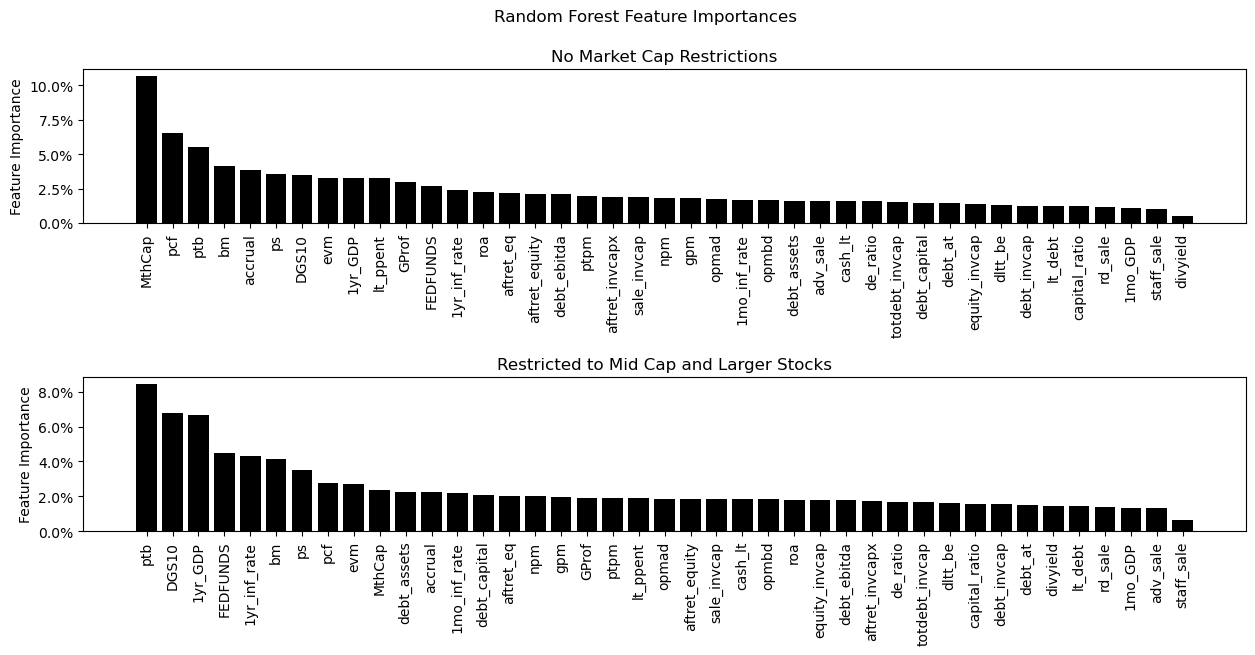

In [49]:
print_col_importances(col_importances_means, col_importances_means_res)

Glossary

ptb - Price/Book
bm - Book/Market
ps - Price/Sales
pcf - Price/Cash flow
evm - Enterprise Value Multiple
debt_assets - Total Debt/Total Assets
accrual - Accruals/Average Assets
debt_capital - Total Debt/Capital
aftret_eq - After-tax Return on Average Common Equity
npm - Net Profit Margin
gpm - Gross Profit Margin
GProf - Gross Profit/Total Assets
ptpm - Pre-tax Profit Margin
lt_ppent - Total Liabilities/Total Tangible Assets
opmad - Operating Profit Margin After Depreciation
aftret_equity - After-tax Return on Total Stockholders’ Equity
sale_invcap - Sales/Invested Capital
cash_lt - Cash Balance/Total Liabilities
opmbd - Operating Profit Margin Before Depreciation
roa - Return on Assets
equity_invcap - Common Equity/Invested Capital
debt_ebitda - debt_ebitda
aftret_invcapx - After-tax Return on Invested Capital
de_ratio - Total Debt/Equity
totdebt_invcap - Total Debt/Invested Capital
dltt_be - Long-term Debt/Book Equity
capital_ratio - Capitalization Ratio
debt_invcap - Long-

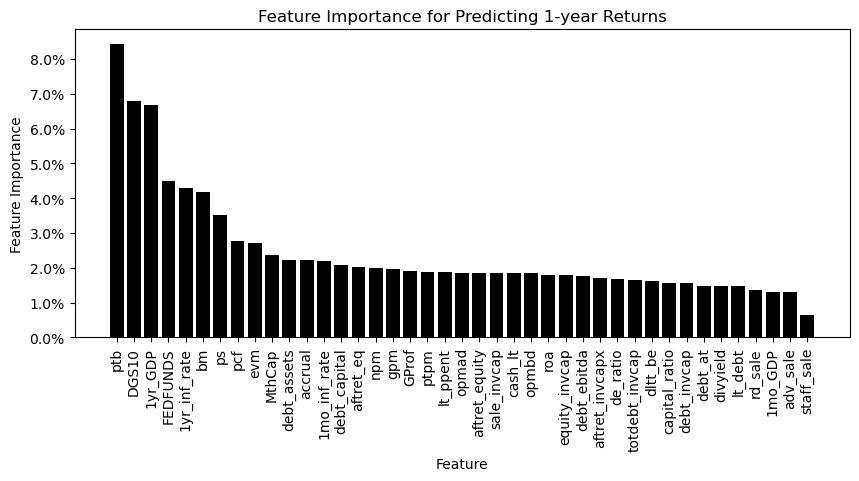

In [27]:
Fig, ax = plt.subplots(1, 1, figsize=(10, 4))
features = np.array(list(col_importances_means.keys()))
importances = np.array(list(col_importances_means.values()))*100
features, importances = features[importances.argsort()[::-1]], np.sort(importances)[::-1]
ax.bar(features, importances, color='k')
ax.set_xticks(ticks=ax.get_xticks(), labels=features, rotation='vertical')
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Feature')
plt.title('Feature Importance for Predicting 1-year Returns')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

print('Glossary\n')
for i, ft in enumerate(features):
    try:
        print(f'{ft} - {glossary[ft]["Ratio"]}')
    except:
        pass

# Patterns and Features Identified by the Model

The next question might be: are there any consistent patterns picked up by the model and do these change over time. First, we will use dimensionality reduction to see if, overall, there are any patterns identified and if so, what are they? Second, we will use the same method to see if this changes over time.

## Dimensionality Reduction - PCA

This first cell creates a new dataframe for each model with a selected column that identifies those stocks selected using the top 30 stocks and those not selected.

In [6]:
def get_df_selected(df, model, cap_restriction=False):
    
    df_dr_all = pd.DataFrame(columns=list(df.columns) + ['selected'])
    
    if model == 'lstm':
        df_test = df
    elif model == 'rf':
        df_test = df.loc[df[cols_to_keep].dropna(how='any').index, :]
    else:
        raise Exception("Model not recognised") 
        
    if cap_restriction == True:
        df_test = df_test[df_test['cap'].isin(['Mid Cap', 'Large Cap', 'Mega Cap'])]
    else:
        pass
    print(df_test.cap.unique())
    
    df_test = df_test.reset_index(drop=True)
    for year in range(1981, 2022):
        if cap_restriction == False:
            if model == 'rf':
                results_yr = wr.s3.read_csv(f's3://dsp-data-vq22301/rf_test_results/rf_results_{year}_raw.csv')
            if model == 'lstm':
                results_yr = wr.s3.read_csv(f's3://dsp-data-vq22301/lstm_test_results/lstm_results_{year}_raw.csv')
        else:
            if model == 'rf':
                results_yr = wr.s3.read_csv(f's3://dsp-data-vq22301/rf_test_results/cap_limit_results/rf_results_Mi_{year}_raw.csv')
            if model == 'lstm':
                results_yr = wr.s3.read_csv(f's3://dsp-data-vq22301/lstm_test_results/cap_limit_results/lstm_results_Mi_{year}_raw.csv')
        df_temp = df_test[df_test['public_date'] == f'{year}-12-31'].reset_index(drop=True)
        df_temp['selected'] = 0
        df_temp.loc[results_yr.ytest_pred_raw.to_numpy().argsort()[-30:], 'selected'] = 1
        df_dr_all = pd.concat([df_dr_all, df_temp])
        print(f'Done {year}')
    
    return df_dr_all.reset_index(drop=True)

rf_selected = get_df_selected(df, 'rf', False)
lstm_selected = get_df_selected(df, 'lstm', False)
rf_res_selected = get_df_selected(df, 'rf', True)
lstm_res_selected = get_df_selected(df, 'lstm', True)

['Small Cap' 'Micro Cap' 'Mid Cap' 'Large Cap' 'Nano Cap' 'Mega Cap']
Done 1981
Done 1982
Done 1983
Done 1984
Done 1985
Done 1986
Done 1987
Done 1988
Done 1989
Done 1990
Done 1991
Done 1992
Done 1993
Done 1994
Done 1995
Done 1996
Done 1997
Done 1998
Done 1999
Done 2000
Done 2001
Done 2002
Done 2003
Done 2004
Done 2005
Done 2006
Done 2007
Done 2008
Done 2009
Done 2010
Done 2011
Done 2012
Done 2013
Done 2014
Done 2015
Done 2016
Done 2017
Done 2018
Done 2019
Done 2020
Done 2021
['Small Cap' 'Micro Cap' 'Mid Cap' 'Large Cap' 'Nano Cap' 'Mega Cap']
Done 1981
Done 1982
Done 1983
Done 1984
Done 1985
Done 1986
Done 1987
Done 1988
Done 1989
Done 1990
Done 1991
Done 1992
Done 1993
Done 1994
Done 1995
Done 1996
Done 1997
Done 1998
Done 1999
Done 2000
Done 2001
Done 2002
Done 2003
Done 2004
Done 2005
Done 2006
Done 2007
Done 2008
Done 2009
Done 2010
Done 2011
Done 2012
Done 2013
Done 2014
Done 2015
Done 2016
Done 2017
Done 2018
Done 2019
Done 2020
Done 2021
['Mid Cap' 'Large Cap' 'Mega Cap']
Done 

In [7]:
def winsorise_cols(df):
    df_wins = df.copy()
    for col in cols_to_keep:
        ub = df_wins[col].median() + (5*median_abs_deviation(df_wins[col], nan_policy='omit'))
        lb = df_wins[col].median() - (5*median_abs_deviation(df_wins[col], nan_policy='omit'))
        df_wins.loc[df_wins[df_wins[col] < lb].index, col] = lb
        df_wins.loc[df_wins[df_wins[col] > ub].index, col] = ub
    return df_wins

def data_prep(df):
    df_dr_all_wins = winsorise_cols(df)
    sc = StandardScaler()
    dr_X = sc.fit_transform(df_dr_all_wins[cols_to_keep].to_numpy())
    dr_X[np.isnan(dr_X)] = 0
    return dr_X

dr_X_rf = data_prep(rf_selected)
dr_X_lstm = data_prep(lstm_selected)
dr_X_rf_res = data_prep(rf_res_selected)
dr_X_lstm_res = data_prep(lstm_res_selected)

In [8]:
def column(matrix, i):
    return [row[i] for row in matrix]

def run_pca(dr_X, df_selected):
    pca = PCA(n_components=2, random_state=777)
    pca.fit(dr_X)
    print(pca.explained_variance_ratio_)
    transformed = PCA(n_components=2, random_state=777).fit_transform(dr_X)
    df_dr_X = pd.DataFrame(dr_X, columns=cols_to_keep)
    
    df_dr_X['x'] = column(transformed, 0)
    df_dr_X['y'] = column(transformed, 1)
    
    df_dr_X['selected'] = df_selected['selected'].astype('str').to_numpy()
    return df_dr_X

pca_rf = run_pca(dr_X_rf, rf_selected)
pca_lstm = run_pca(dr_X_lstm, lstm_selected)
pca_rf_res = run_pca(dr_X_rf_res, rf_res_selected)
pca_lstm_res = run_pca(dr_X_lstm_res, lstm_res_selected)

[0.24705576 0.18350204]
[0.23459598 0.17282275]
[0.24158608 0.16342504]
[0.22516524 0.15812366]


In [9]:
def print_pca(pca_df, df_selected):
    fig = px.scatter(pca_df, x='x', y='y', color='selected', color_discrete_map={'0': 'red', '1': 'green'}, hover_data=Top_10_features.tolist()) #, hover_data=df_dr_all.columns

    fig.update_layout(plot_bgcolor='white')
    fig.update_traces(marker=dict(size=3, cmax=0.3, cmin=-1))

    fig.show()

In [10]:
def plot_pca_plt(df1, df2, df_name, restricted=False):
    Fig, ax = plt.subplots(1, 2, figsize=(10, 4.25))
    for i, df in enumerate([df1, df2]):
        selected = df[df['selected'] == '1']
        unselected = df[df['selected'] == '0']
        ax[i].scatter(x=unselected['x'], y=unselected['y'], c='red', zorder=1, label='Not selected', s=1)
        ax[i].scatter(x=selected['x'], y=selected['y'], c='green', zorder=2, label='Selected', s=1)
        if restricted == True:
            title = f'{df_name[i]} (cap restricted) PCA - Stocks Selected'
        else:
            title = f'{df_name[i]} (entire universe) PCA - Stocks Selected'
        ax[i].set_title(title, fontsize=10)
        ax[i].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
        ax[i].legend(loc='lower left', markerscale=2, framealpha=0.9)

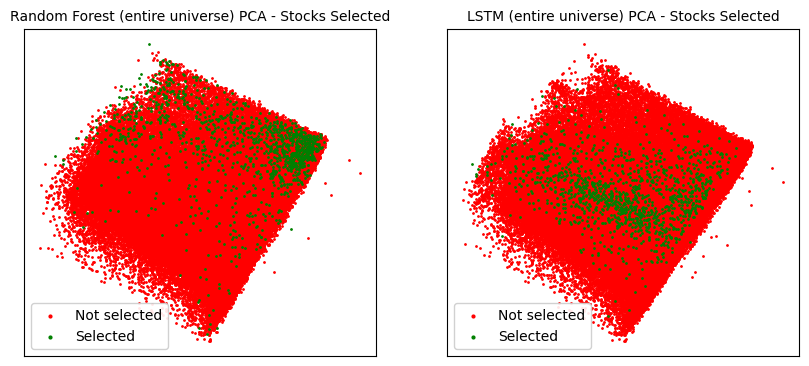

In [28]:
plot_pca_plt(pca_rf, pca_lstm, ['Random Forest', 'LSTM'])

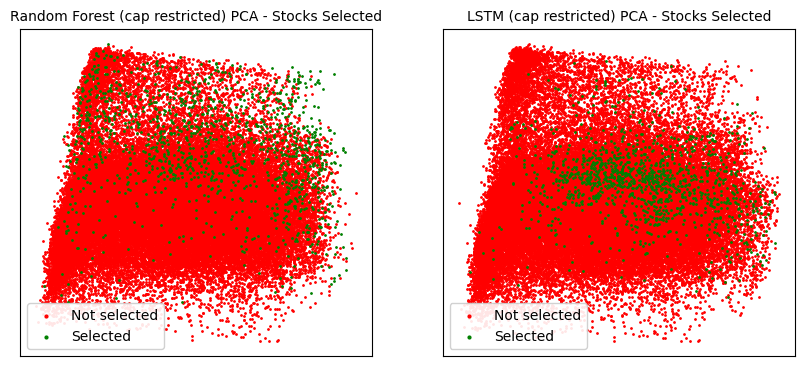

In [29]:
plot_pca_plt(pca_rf_res, pca_lstm_res, ['Random Forest', 'LSTM'], True)

#### Market cap stat for thesis

In [250]:
rf_selected['MthCap'][np.logical_and(rf_selected['public_date'] == '2021-12-31', rf_selected['selected'] == 1)].sum()

988440.7999999999

## Comparison of Means

In [11]:
stock_columns = cols_to_keep[:-6]
no_test = ['rd_sale', 'adv_sale', 'staff_sale', 'divyield']
test = []
for col in stock_columns:
    if col in stock_columns and col not in no_test:
        test.append(col)

In [23]:
from scipy.stats import t

def f_test(group1, group2):
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = group1.size-1
    dun = group2.size-1
    p_value = 1-stats.f.cdf(f, nun, dun)
    return f, p_value

def get_ci(x1, x2):
    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)
    
    pooled_se = np.sqrt(v1 / n1 + v2 / n2)
    delta = m1-m2
    
    df = (v1 / n1 + v2 / n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))
    
    bound = t.ppf(0.975,df)*pooled_se 
  
    return bound

def compare_means(pca_df):
    selected = pca_df[test][pca_df['selected'] == '1'].mean()
#     selected_std = pca_df[stock_columns][pca_df['selected'] == '1'].std()
#     selected_count = pca_df[stock_columns][pca_df['selected'] == '1'].count()
    unselected = pca_df[test][pca_df['selected'] == '0'].mean()
#     unselected_std = pca_df[stock_columns][pca_df['selected'] == '0'].std()
#     unselected_count = pca_df[stock_columns][pca_df['selected'] == '0'].count()
    f_tests = []
    for col in test:
        f_tests.append("{:.4f}".format(f_test(pca_rf[col][pca_rf['selected'] == '0'].to_numpy(), pca_rf[col][pca_rf['selected'] == '1'].to_numpy())[1]))
    
    bounds = []
    for col in test:
        bounds.append(get_ci(pca_df[col][pca_df['selected'] == '1'].to_numpy(), pca_df[col][pca_df['selected'] == '0'].to_numpy()))
    
    t_tests = []
    for i, col in enumerate(test):
        if float(f_tests[i]) <= 0.05:
            t_tests.append("{:.4f}".format(stats.ttest_ind(pca_rf[col][pca_rf['selected'] == '0'].to_numpy(), pca_rf[col][pca_rf['selected'] == '1'].to_numpy(), equal_var = False)[1]))
        else:
            t_tests.append("{:.4f}".format(stats.ttest_ind(pca_rf[col][pca_rf['selected'] == '0'].to_numpy(), pca_rf[col][pca_rf['selected'] == '1'].to_numpy(), equal_var = True)[1]))
    
    df_compare = pd.DataFrame({'Selected Means': selected, 'Unselected Means': unselected, 'Difference (Selected - Unselected)': selected - unselected, 'F-test (p-value)': f_tests, 't-tests (p-value)': t_tests, 'CI': bounds})
    stat_columns = list(df_compare.columns)

    for idx in df_compare.index:
        try:
            df_compare.loc[idx, 'Ratio Name'] = glossary[idx]['Ratio']
            df_compare.loc[idx, 'Ratio Category'] = glossary[idx]['Category']
            df_compare.loc[idx, 'Ratio Description'] = glossary[idx]['Formula']
        except:
            pass
    
    top_10 = df_compare[['Ratio Name', 'Ratio Category', 'Ratio Description'] + stat_columns]  # [df_compare['t-tests (p-value)'].astype('float') <=0.05]
    return top_10  # .reindex(top_10['Difference (Selected - Unselected)'].abs().sort_values(ascending=False).index).iloc[:10, :]

In [53]:
compare_means(pca_rf).reindex(compare_means(pca_rf)['Difference (Selected - Unselected)'].abs().sort_values(ascending=False).index).iloc[:10, :]

,Ratio Name,Ratio Category,Ratio Description,Selected Means,Unselected Means,Difference (Selected - Unselected),F-test (p-value),t-tests (p-value),CI
ptpm,Pre-tax Profit Margin,Profitability,Pretax Income as a fraction of Sales,-1.559169,0.012454,-1.571623,0.7154,0.0000,0.056232
npm,Net Profit Margin,Profitability,Net Income as a fraction of Sales,-1.538493,0.012289,-1.550782,0.3314,0.0000,0.055132
opmad,Operating Profit Margin After Depreciation,Profitability,Operating Income After Depreciation as a fract...,-1.490797,0.011908,-1.502705,0.0241,0.0000,0.053470
roa,Return on Assets,Profitability,Operating Income Before Depreciation as a frac...,-1.466531,0.011714,-1.478245,1.0000,0.0000,0.062186
aftret_equity,After-tax Return on Total Stockholders’ Equity,Profitability,Net Income as a fraction of average of Total S...,-1.461604,0.011675,-1.473278,1.0000,0.0000,0.061842
opmbd,Operating Profit Margin Before Depreciation,Profitability,Operating Income Before Depreciation as a frac...,-1.421929,0.011358,-1.433287,1.0000,0.0000,0.061243
aftret_eq,After-tax Return on Average Common Equity,Profitability,Net Income as a fraction of average of Common ...,-1.403364,0.011209,-1.414573,1.0000,0.0000,0.066541
aftret_invcapx,After-tax Return on Invested Capital,Profitability,Net Income plus Interest Expenses as a fractio...,-1.282420,0.010243,-1.292664,1.0000,0.0000,0.061778
evm,Enterprise Value Multiple,Valuation,Multiple of Enterprise Value to EBITDA,-0.869770,0.006947,-0.876717,0.7261,0.0000,0.056650
MthCap,NaN,NaN,NaN,-0.835504,0.006674,-0.842178,0.0000,0.0000,0.022351


In [229]:
compare_means(pca_lstm).reindex(compare_means(pca_lstm)['Difference (Selected - Unselected)'].abs().sort_values(ascending=False).index).iloc[:10, :]

,Ratio Name,Ratio Category,Ratio Description,Selected Means,Unselected Means,Difference (Selected - Unselected),F-test (p-value),t-tests (p-value),CI
bm,Book/Market,Valuation,Book Value of Equity as a fraction of Market V...,1.819289,-0.012871,1.832160,1.0000,0.0000,0.067540
ptb,Price/Book,Valuation,Multiple of Market Value of Equity to Book Val...,-0.872886,0.006175,-0.879062,1.0000,0.0000,0.028779
ps,Price/Sales,Valuation,Multiple of Market Value of Equity to Sales,-0.713223,0.005046,-0.718268,1.0000,0.0000,0.033732
MthCap,NaN,NaN,NaN,-0.615920,0.004357,-0.620277,0.0000,0.0000,0.037068
accrual,Accruals/Average Assets,Other,Accruals as a fraction of average Total Assets...,-0.566188,0.004006,-0.570193,1.0000,0.0000,0.061241
npm,Net Profit Margin,Profitability,Net Income as a fraction of Sales,-0.408338,0.002889,-0.411227,0.3314,0.0000,0.049279
aftret_equity,After-tax Return on Total Stockholders’ Equity,Profitability,Net Income as a fraction of average of Total S...,-0.395422,0.002798,-0.398219,1.0000,0.0000,0.059699
ptpm,Pre-tax Profit Margin,Profitability,Pretax Income as a fraction of Sales,-0.393493,0.002784,-0.396277,0.7154,0.0000,0.047911
aftret_invcapx,After-tax Return on Invested Capital,Profitability,Net Income plus Interest Expenses as a fractio...,-0.372336,0.002634,-0.374970,1.0000,0.0000,0.058457
sale_invcap,Sales/Invested Capital,Efficiency,Sales per dollar of Invested Capital,0.345182,-0.002442,0.347624,1.0000,0.0000,0.064420


In [230]:
compare_means(pca_rf_res).reindex(compare_means(pca_rf_res)['Difference (Selected - Unselected)'].abs().sort_values(ascending=False).index).iloc[:10, :]

,Ratio Name,Ratio Category,Ratio Description,Selected Means,Unselected Means,Difference (Selected - Unselected),F-test (p-value),t-tests (p-value),CI
npm,Net Profit Margin,Profitability,Net Income as a fraction of Sales,-1.201321,0.023284,-1.224605,0.3314,0.0000,0.067177
ptpm,Pre-tax Profit Margin,Profitability,Pretax Income as a fraction of Sales,-1.194475,0.023151,-1.217627,0.7154,0.0000,0.067094
aftret_equity,After-tax Return on Total Stockholders’ Equity,Profitability,Net Income as a fraction of average of Total S...,-1.161487,0.022512,-1.183999,1.0000,0.0000,0.075574
aftret_eq,After-tax Return on Average Common Equity,Profitability,Net Income as a fraction of average of Common ...,-1.095472,0.021232,-1.116705,1.0000,0.0000,0.078191
opmad,Operating Profit Margin After Depreciation,Profitability,Operating Income After Depreciation as a fract...,-0.972557,0.018850,-0.991407,0.0241,0.0000,0.067161
aftret_invcapx,After-tax Return on Invested Capital,Profitability,Net Income plus Interest Expenses as a fractio...,-0.952684,0.018465,-0.971149,1.0000,0.0000,0.075614
roa,Return on Assets,Profitability,Operating Income Before Depreciation as a frac...,-0.869110,0.016845,-0.885955,1.0000,0.0000,0.058426
equity_invcap,Common Equity/Invested Capital,Capitalisation,Common Equity as a fraction of Invested Capital,-0.781738,0.015152,-0.796890,1.0000,0.0000,0.085599
bm,Book/Market,Valuation,Book Value of Equity as a fraction of Market V...,0.743421,-0.014409,0.757830,1.0000,0.0000,0.090052
opmbd,Operating Profit Margin Before Depreciation,Profitability,Operating Income Before Depreciation as a frac...,-0.736607,0.014277,-0.750884,1.0000,0.0000,0.070207


In [231]:
compare_means(pca_lstm_res).reindex(compare_means(pca_lstm_res)['Difference (Selected - Unselected)'].abs().sort_values(ascending=False).index).iloc[:10, :]

,Ratio Name,Ratio Category,Ratio Description,Selected Means,Unselected Means,Difference (Selected - Unselected),F-test (p-value),t-tests (p-value),CI
bm,Book/Market,Valuation,Book Value of Equity as a fraction of Market V...,1.725823,-0.030447,1.756270,1.0000,0.0000,0.067023
ptb,Price/Book,Valuation,Multiple of Market Value of Equity to Book Val...,-0.854272,0.015071,-0.869343,1.0000,0.0000,0.032709
ps,Price/Sales,Valuation,Multiple of Market Value of Equity to Sales,-0.658235,0.011613,-0.669847,1.0000,0.0000,0.034646
debt_ebitda,debt_ebitda,Financial Soundness,Gross Debt as a fraction of EBITDA,0.620537,-0.010948,0.631485,1.0000,0.0000,0.066900
debt_assets,Total Debt/Total Assets,Solvency,Total Debt as a fraction of Total Assets,0.588741,-0.010387,0.599127,1.0000,0.3154,0.056538
equity_invcap,Common Equity/Invested Capital,Capitalisation,Common Equity as a fraction of Invested Capital,-0.554440,0.009781,-0.564222,1.0000,0.0000,0.064491
debt_invcap,Long-term Debt/Invested Capital,Capitalisation,Long-term Debt as a fraction of Invested Capital,0.511750,-0.009028,0.520778,1.0000,0.7816,0.065043
aftret_equity,After-tax Return on Total Stockholders’ Equity,Profitability,Net Income as a fraction of average of Total S...,-0.507957,0.008961,-0.516918,1.0000,0.0000,0.051012
capital_ratio,Capitalization Ratio,Capitalisation,Total Long-term Debt as a fraction of the sum ...,0.501106,-0.008841,0.509947,1.0000,0.9198,0.065999
debt_capital,Total Debt/Capital,Solvency,"Total Debt as a fraction of Total Capital, whe...",0.490754,-0.008658,0.499412,1.0000,0.0002,0.059307


In [24]:
compare_graph_df = pd.DataFrame(index=test)
for model, df in [('Random Forest - Unrestricted', pca_rf), ('LSTM - Unrestricted', pca_lstm), ('Random Forest - Restricted', pca_rf_res), ('LSTM - Restricted', pca_lstm_res)]:
    compare_graph_df[f'{model} - Mean Difference'] = compare_means(df)['Difference (Selected - Unselected)']
    compare_graph_df[f'{model} - CI'] = compare_means(df)['CI']

In [25]:
compare_graph_df

,Random Forest - Unrestricted - Mean Difference,Random Forest - Unrestricted - CI,LSTM - Unrestricted - Mean Difference,LSTM - Unrestricted - CI,Random Forest - Restricted - Mean Difference,Random Forest - Restricted - CI,LSTM - Restricted - Mean Difference,LSTM - Restricted - CI
bm,0.599360,0.086490,1.832160,0.067540,0.757830,0.090052,1.756270,0.067023
evm,-0.876717,0.056650,-0.239099,0.055835,-0.446382,0.087402,-0.092056,0.055598
ps,0.151007,0.070942,-0.718268,0.033732,-0.129555,0.068421,-0.669847,0.034646
pcf,-0.473097,0.041801,-0.245138,0.039936,-0.499960,0.064093,-0.454244,0.042796
npm,-1.550782,0.055132,-0.411227,0.049279,-1.224605,0.067177,-0.317270,0.054037
opmbd,-1.433287,0.061243,-0.212531,0.045749,-0.750884,0.070207,0.004557,0.055601
opmad,-1.502705,0.053470,-0.280947,0.045213,-0.991407,0.067161,-0.098420,0.053515
gpm,-0.782828,0.089427,-0.024490,0.045513,-0.285617,0.077461,-0.255508,0.050481
ptpm,-1.571623,0.056232,-0.396277,0.047911,-1.217627,0.067094,-0.337220,0.053476
roa,-1.478245,0.062186,-0.269002,0.048705,-0.885955,0.058426,-0.408490,0.046598


In [34]:
def selected_stocks_features_graph(model1, model2):

    features = compare_graph_df.index
    mean_differences = {
        f'{model1}': compare_graph_df[f'{model1} - Mean Difference'].tolist(),
        f'{model2}': compare_graph_df[f'{model2} - Mean Difference'].tolist(),
    }

    bounds = [
        compare_graph_df[f'{model1} - CI'].tolist(),
        compare_graph_df[f'{model2} - CI'].tolist()
    ]

    x = np.arange(len(features))
    width = 0.25
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=(10, 5))

    for i, (attribute, measurement) in enumerate(mean_differences.items()):
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=bounds[i])
        multiplier += 1

    ax.set_ylabel('Mean Differences (Selected - Unselected) (σ)')
    ax.set_xlabel('Features')
    ax.set_title("Comparison of Means between Selected and Unselected Stocks by each Strategy (σ)")
    ax.set_xticks(x + width, features, rotation='vertical', fontsize='small')
    ax.set_yticks(np.arange((ax.get_ylim()[0]//0.25)*0.25, ((ax.get_ylim()[1]//0.25)+1)*0.25, 0.25))
    ax.legend(loc='best', ncols=2)
    plt.axhline(y=0, color='k', linewidth=0.5)
    plt.grid(axis='y', linewidth=0.25)

    plt.show()

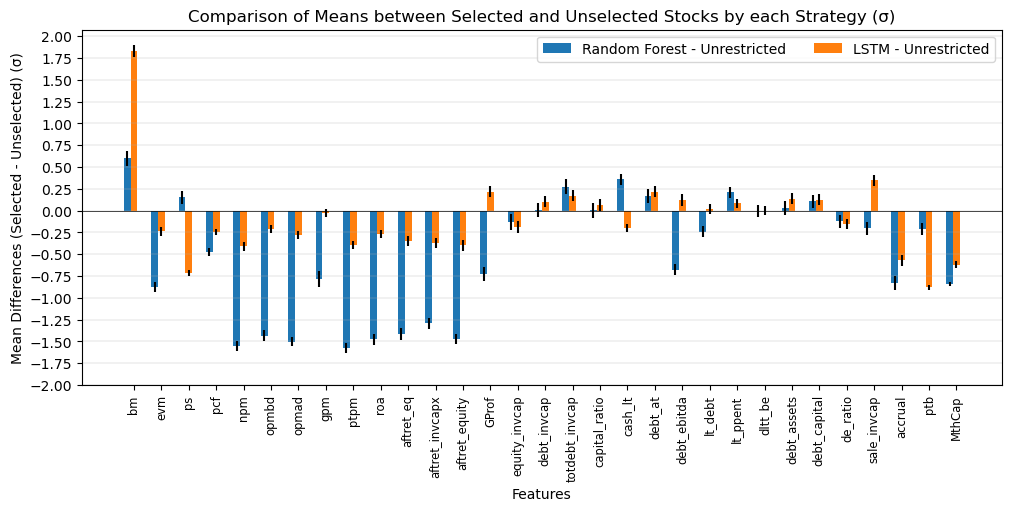

In [35]:
selected_stocks_features_graph('Random Forest - Unrestricted', 'LSTM - Unrestricted')

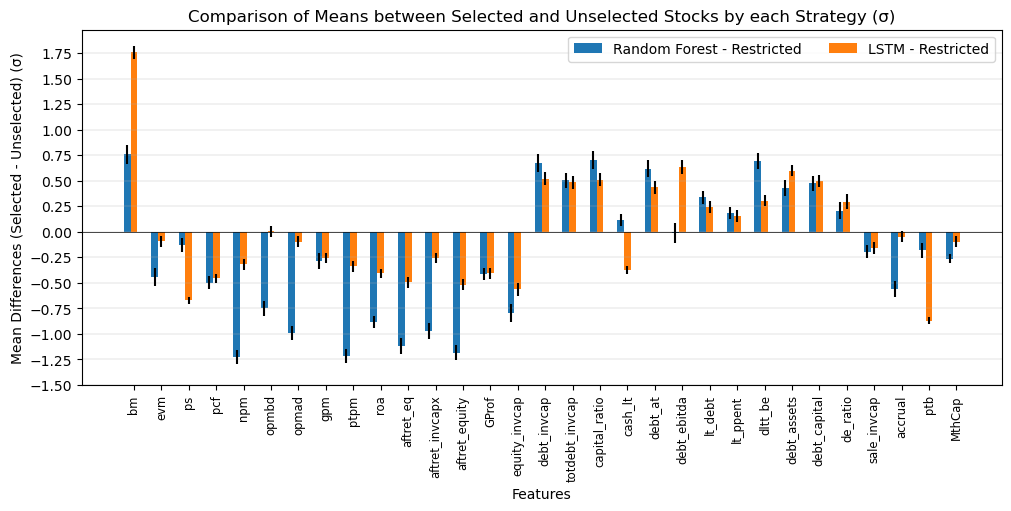

In [36]:
selected_stocks_features_graph('Random Forest - Restricted', 'LSTM - Restricted')